# Notebook sulla cluster analysis

>In questo notebook eseguiamo la cluster analysis sul dataset, a tale scopo abbiamo usato le librerie di **Sklearn e Scipy** per eseguire i 3 tipi di clustering visti a lezione.
Il notebook comincia con l'importazioni degli strumenti di lavoro e il caricamento del dataset trattato nella fase di pre processing.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import random
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn import preprocessing # per normalizzare o standardizzare i dati

In [2]:
from path import Path
PROJ_DIR = Path().getcwd().parent
DATA_DIR = PROJ_DIR / "data"
INTERIM_DIR = DATA_DIR / "interim"
filename = INTERIM_DIR / "datasetUnione.csv"
print(filename)
sns.set(rc={'figure.figsize':(13.7,10.27)})

/home/matthew/Scrivania/dmo_progetto/data/interim/datasetUnione.csv


In [3]:
dataset = pd.read_csv(filename)
#dataset = dataset.drop("Coorte", axis=1)


## Definizione dei metodi di clustering

> La libreria di **Sk-learn** mette a disposizione tutti i clustering visti a lezione ma per il **clustering gerarchcio** abbiamo usato anche **Scipy**, perchè la sua implementazione del clustering disegna il dendogramma e permette di ottenere facilmente **coefficiente di cophenetic** per la valutazione del clustering.
Per automatizzare l'analisi del dataset ed evitare di scrivere più codice del necessario, abbiamo scritto delle funzioni che utilizzano gli algoritmi di clustering e prendono in ingresso il dataset e i parametri necessari per settare gli algoritmi in modo corretto. Inoltre queste funzioni al loro interno contegono un oggetto di tipo **StandardScaler** che attraverso il metodo **fit_transform** standardizza il dataset secondo lo [z-score](https://it.wikipedia.org/wiki/Standardizzazione_(statistica)).
Tutte le funzioni ad eccezione della funzione **kmeans** che restituisce anche il dataframe dei centrodi, restituiscono il dataset standardizzato e una copia del dataset normale entrambi con la colonna **cluster** che rappresenta il risultato finale dell'applicazione dell'algoritmo di clustering. 
Come detto in precedenza, le nostre funzioni prendono in input i parametri da passare poi agli algoritmi, pertanto forniamo una breve descrizione di questi parametri.

>Per la funzione kmeans:
* **k** specifica il numero di cluster
* **method** specifica la versione del k-means da utilizzare, per esempio **k-means++** 
* **RS**, specifica il valore del parametro [**RANDOM_STATE**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), tale parametro determina la generazione causale dei centrodi iniziali e secondo la [documentazione di **Sk-learn**](https://scikit-learn.org/stable/glossary.html#term-random-state) si consiglia di impostarlo a 42, perchè 42 è la risposta alla domanda finale della vita, dell'universo e di tutto

> Per le funzioni del clustering gerarchico:
* **method** specifica la strategia di fusione da utilizzare tra: **single link**, **complete link**, **average link** e **ward**
* **k**, indica il numero di cluster da trovare

> Per la funzione dbscan:
* **eps** specifica il raggio di azione per intercettare i punti
* **minPoints** specifica il numero di minimo di punti da intercettare all'interno del raggio per classifcare un punto come core points


In [4]:
def kmeans(dataset, k,method,RS=42 ):
    scaler = preprocessing.StandardScaler()
    columns_name = dataset.columns
    datasetStandar = scaler.fit_transform(dataset)
    datasetStandar = pd.DataFrame(data = datasetStandar, columns = columns_name)
    km = KMeans(n_clusters = k,init=method,random_state=RS)
    clustering = km.fit(datasetStandar)
    print("clustering information:\n","Valore SSE: ", km.inertia_,"\n",
         "Numero di iterazioni", km.n_iter_,"\n",
         clustering)
    dataset_copy = dataset.copy()
    dataset_copy['cluster'] = km.labels_
    datasetStandar['cluster'] = km.labels_
    centroid = datasetStandar.groupby("cluster").mean()
    return centroid, datasetStandar, dataset_copy
    

In [5]:
def c_hierarchic_scipy(dataset, method,fs=(30,23)):
    scaler = preprocessing.StandardScaler()
    columns_name = dataset.columns
    datasetStandar = scaler.fit_transform(dataset)
    datasetStandar = pd.DataFrame(data = datasetStandar, columns = columns_name)
    data_clustering = np.array(datasetStandar.iloc[:]) #trasforma le righe in array numpy
    labelList = range(0, len(data_clustering))
    linked = linkage(data_clustering, method) #esegue il clustering gerarchico
    #plt.figure(figsize=fs)
    dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True) #visualizza il dendegogramma
    CPCC(linked, data_clustering, method)

In [6]:
def c_hierarchic_Sklearn(dataset, k, method):
    scaler = preprocessing.StandardScaler()
    columns_name = dataset.columns
    datasetStandar = scaler.fit_transform(dataset)
    datasetStandar = pd.DataFrame(data = datasetStandar, columns = columns_name)
    ac = AgglomerativeClustering(n_clusters=k, linkage=method)
    clustering = ac.fit(datasetStandar) #adatta il modello ai dati
    print("Clustering information: ", clustering)
    dataset_copy = dataset.copy()
    dataset_copy['cluster'] = ac.labels_
    datasetStandar['cluster'] = ac.labels_
    return datasetStandar, dataset_copy

In [7]:
def dbScan(dataset, eps, minPoints):
    scaler = preprocessing.StandardScaler()
    columns_name = dataset.columns
    datasetStandar = scaler.fit_transform(dataset)
    datasetStandar = pd.DataFrame(data = datasetStandar, columns = columns_name)
    dbscan = DBSCAN(eps=eps, min_samples= minPoints)
    clustering = dbscan.fit(datasetStandar)
    print("clustering information ", clustering)
    dataset_copy = dataset.copy()
    dataset_copy['cluster'] = dbscan.labels_
    datasetStandar['cluster'] = dbscan.labels_
    return datasetStandar, dataset_copy

## Definizione dei metodi di visualizzazione del clustering

>Questi metodi visualizzano i risultati restituiti dagli algoritmi, i metodi **visDataKmeans** e **DataVisClustering** utilizzano il dataframe dei centroidi calcolato dalla funzione **kmeans** per visualizzarli nel grafico.
Ogni metodo prende in input il dataset e il nome delle variabili che si desidera osservare.
Gli altri parametri, **path** e **DatasetName** servono solo a salvare il grafico disegnato.
Abbiamo poi definito le equivalenti funzioni **visDataKmeansJitter** e **DataVisClusteringJitter** che consentono di inserire del rumore nei dati in modo tale da visualizzarli impostando un valore per il parametro jitter.

In [8]:
def visDataKmeans(dataset, var1Name, var2Name, centroidVar1, centroidVar2, path, DatasetName):
    plot = sns.scatterplot(x = var1Name, y = var2Name, hue=dataset.cluster, palette="Set2", data=dataset)
    plt.scatter(centroidVar1, centroidVar2, linewidths=1, marker="+",s=150, c="black")
    title = "K-means: "+var1Name+" Vs. "+var2Name+" dataset name: "+DatasetName
    plt.title(title)
    path+="/"+"K-means"+var1Name+var2Name+DatasetName
    fig = plot.get_figure()
    fig.savefig(path)

In [9]:
def dataVisClustering(dataset, var1Name, var2Name, path, DatasetName,clusteringName=None):
    plot = sns.scatterplot(x = var1Name, y = var2Name, hue=dataset.cluster, palette="Set2", data=dataset)
    if(clusteringName=="dbscan"):
        title = "DBSCAN: "+var1Name+" Vs. "+var2Name+" dataset name: "+DatasetName
        plt.title(title)
        dbsclusters=dataset[dataset.cluster != -1]
        dbnoise=dataset[dataset.cluster == -1]
        plt.scatter(dbnoise[var1Name], dbnoise[var2Name], marker="X", s=35, c="red") # mostra il rumore
    else:
        title = clusteringName+var1Name+" Vs. "+var2Name+" dataset name: "+DatasetName
        plt.title(title)
        
    path+="/"+clusteringName+var1Name+var2Name+DatasetName
    fig = plot.get_figure()
    fig.savefig(path)

In [10]:
def visDataKmeansJitter(dataset, var1Name, var2Name, centroidVar1, centroidVar2, path, DatasetName, jitter = 0):
    h_jitter = 0.1*jitter
    v_jitter = 0.1*jitter
    datasetj=dataset.copy()
    var1j=dataset[var1Name].copy()
    var2j=dataset[var2Name].copy()
    l1 = len (dataset[var1Name])
    l2 = len (dataset[var2Name])
    for i in range (0, l1):
        jit=random.uniform(-h_jitter, h_jitter)
        var1j[i]=var1j[i]+jit
    for i in range (0, l2):
        jit=random.uniform(-v_jitter, v_jitter)
        var2j[i]=var2j[i]+jit
    datasetj[var1Name]=var1j
    datasetj[var2Name]=var2j
    visDataKmeans(datasetj, var1Name, var2Name, centroidVar1, centroidVar2, path, DatasetName)

In [11]:
def dataVisClusteringJitter(dataset, var1Name, var2Name, path, DatasetName,clusteringName, jitter = 0):
    h_jitter = 0.1*jitter
    v_jitter = 0.1*jitter
    datasetj=dataset.copy()
    var1j=dataset[var1Name].copy()
    var2j=dataset[var2Name].copy()
    l1 = len (dataset[var1Name])
    l2 = len (dataset[var2Name])
    for i in range (0, l1):
        jit=random.uniform(-h_jitter, h_jitter)
        var1j[i]=var1j[i]+jit
    for i in range (0, l2):
        jit=random.uniform(-v_jitter, v_jitter)
        var2j[i]=var2j[i]+jit
    datasetj[var1Name]=var1j
    datasetj[var2Name]=var2j
    dataVisClustering(datasetj, var1Name, var2Name, path, DatasetName, clusteringName)

## Definizione dei metodi di valutazione del clustering

>Una delle difficoltà di questo progetto di Data Mining è il fatto che non si conoscono a priori le etichette di classe.
Pertanto per valutare i cluster ottenuti abbiamo usato delle metriche itrinsiche per confrontare i vari risultati.
A tale scopo abbiamo definito due metriche per il Kmeans, il **coefficiente di silhouette** e il **metodo Elbow** che ci hanno permesso di determinare il valore ottimale di k attraverso un grafico.
Il metodo elbow non è stato visto a lezione e utilizza l' **SSE** come misura di qualità. Sappiamo che aumentando il numero di cluster il valore SSE cala, questo perchè i dati nei cluster sarano più vicini ai centroidi assegnati. L'idea è che il valore di k viene identificato nel punto in cui la curva del SSE subisce un decisivo incremento, ovvero il punto di massimo locale della curva che rappresenta l'SSE. 
Per il clustering gerarchcico  abbiamo definito la funzione **CPCC** che calcola il **coefficiente di cophenetic**, mentre per il DBSCAN abbiamo scritto una procedura **findParamerDBScan** per trovare il valore di eps in funzione dei minpoints, usando il **k-nearest neighbors**.
In questo caso quello che facciamo per trovare il valore ottimale di Eps è:
* adattare il KNN ai dati 
* estrarre dal KNN la matrice delle distanze
* prendere la k-essima colonna dalla matrice e ordinarla in modo decrescente
* passare all'oggetto matplotlib la colonna ordinata e gli indici per disegnare la curva




In [12]:
def silhouette_Coefficient(dataset, k, method, Rs=42, fs=(30,23)):
    scaler = preprocessing.StandardScaler()
    columns_name = dataset.columns
    datasetStandar = scaler.fit_transform(dataset)
    datasetStandar = pd.DataFrame(data = datasetStandar, columns = columns_name)
    k_range = range(2,k)
    scores = []
    for i in k_range:
        km = KMeans(n_clusters = i,init=method,random_state=Rs)
        km.fit(datasetStandar)
        scores.append(metrics.silhouette_score(datasetStandar,km.labels_))

    #plt.figure(figsize=fs)
    plt.plot(k_range,scores)
    plt.title("Silhouette Coefficient")
    plt.xlabel("Numero di cluster")
    plt.ylabel("Valore del coefficiente di silhoutte")
    plt.grid(True)
    print("Il valore massimo del coefficiente di silhouette è ",max(scores))

In [13]:
def elbow_method(dataset, k, method, Rs=42, fs=(30,23)):
    scaler = preprocessing.StandardScaler()
    columns_name = dataset.columns
    datasetStandar = scaler.fit_transform(dataset)
    datasetStandar = pd.DataFrame(data = datasetStandar, columns = columns_name)
    k_range = range(2,k)
    scores = []
    for i in k_range:
        km = KMeans(n_clusters = i,init=method,random_state=Rs)
        km.fit(datasetStandar)
        scores.append(km.inertia_) #inserisci nella lista l'SSE del cluster ottenuto
                 
    #plt.figure(figsize=fs)
    plt.plot(k_range,scores)
    plt.title("Elbow method")
    plt.xlabel("Numero di cluster")
    plt.ylabel("Valore del SSE")
    plt.grid(True)
    

In [14]:
def CPCC(clustering, data_clustering, method):
    cf, coph_dists = cophenet(clustering, pdist(data_clustering))
    print("Il valore del coefficiente  di correlazione di CoPhenetic per clustering gerarchico con il metodo ",method, " è ", cf);
    #print("La matrice delle distanze del clustering è:\n", coph_dists)
    return cf, coph_dists


In [15]:
def findParamerDBScan(dataset,k_neighbors=4):
    scaler = preprocessing.StandardScaler()
    columns_name = dataset.columns
    datasetStandar = scaler.fit_transform(dataset)
    datasetStandar = pd.DataFrame(data = datasetStandar, columns = columns_name)
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(datasetStandar)
    distances, indices = nbrs.kneighbors(datasetStandar)
    distanceDec = sorted(distances[:,k_neighbors-1], reverse=True) #prendi l'ultima colonna e ordinala in senso decrescente
    indices = range(0,len(dataset))
    plt.xlabel("Punti ordinati secondo la distanza del loro k-esimo vicino")
    plt.ylabel("Distanza dal k-esimo vicino")
    plt.plot(indices, distanceDec)
    plt.grid(True)

### Analisi dei dati

>Abbiamo eseguito la cluster analysis su tre sottoinsiemi di dati per trovare dei pattern.
Il primo sottoinsime dei dati usa le variabili voto_test, voto_medio e genere,
il secondo sottoinsieme di dati usa solo i corsi dati dagli studenti (tolto inglese), l'ultimo sottoinsieme di dati usa le variabili AN1, PRG, voto_medio e Scuola_provenienza.

### Analisi dei dati con le variabili Voto_test, Voto_medio e Genere

In [16]:
path1 = './clustering/clusterSchool/kmeans'
path2 = './clustering/clusterSchool/dbscan'
path3 = './clustering/clusterSchool/gerachico'
dataset1 = dataset[["Voto_test", "Voto_medio", "Genere"]] #dataset 1

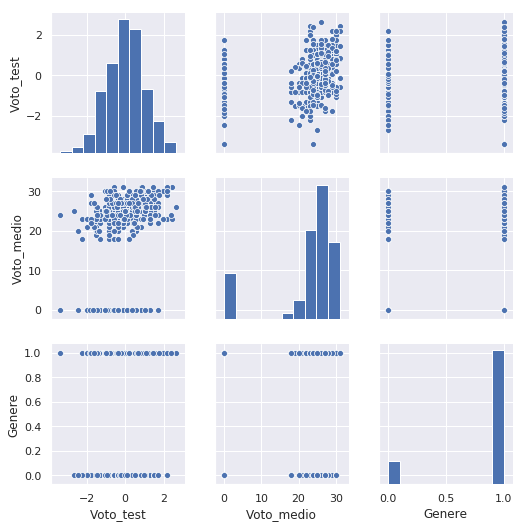

In [17]:
sns.pairplot(dataset1)

## Clustering gerarchico

Il valore del coefficiente  di correlazione di CoPhenetic per clustering gerarchico con il metodo  average  è  0.9011153079191754


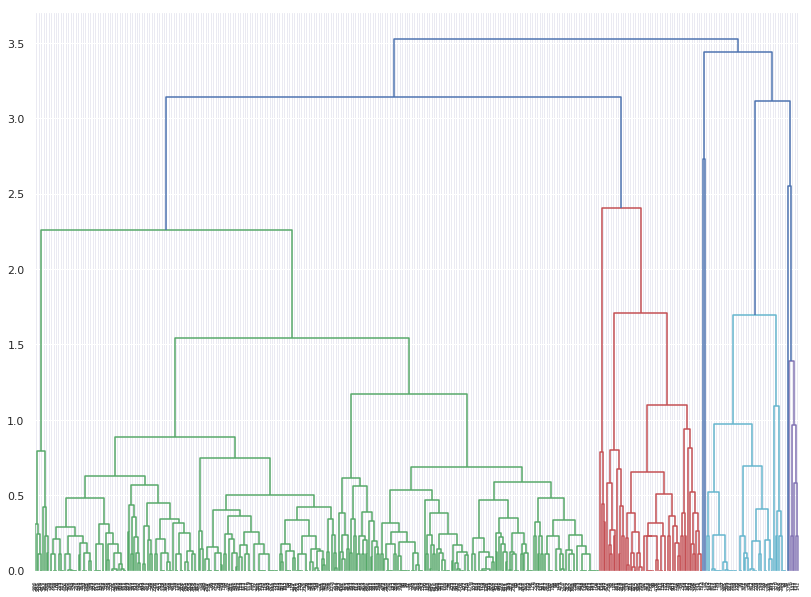

In [18]:
c_hierarchic_scipy(dataset1, "average",fs=(30,23))

In [19]:
datasetStandarHC1, datasetHC1 = c_hierarchic_Sklearn(dataset1, 6, "average")

Clustering information:  AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=6, pooling_func='deprecated')


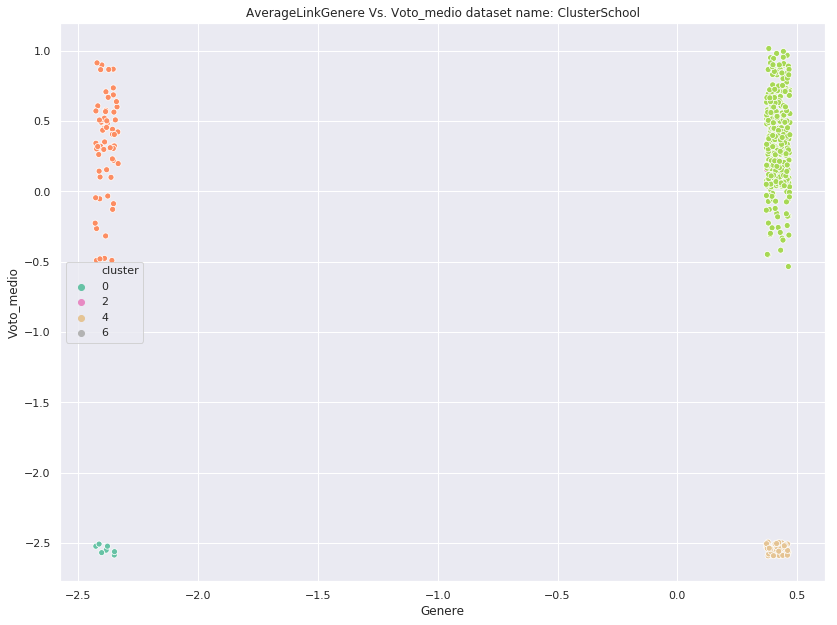

In [106]:
dataVisClusteringJitter(datasetStandarHC1, "Genere", "Voto_medio", path3, "ClusterSchool",clusteringName="AverageLink", jitter=0.5)

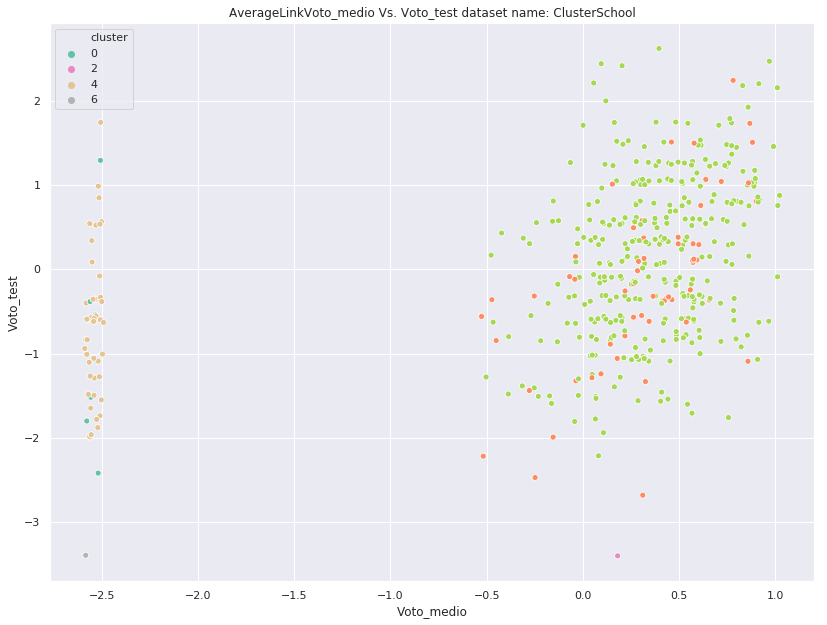

In [21]:
dataVisClusteringJitter(datasetStandarHC1, "Voto_medio", "Voto_test", path3, "ClusterSchool",clusteringName="AverageLink", jitter=0.5)

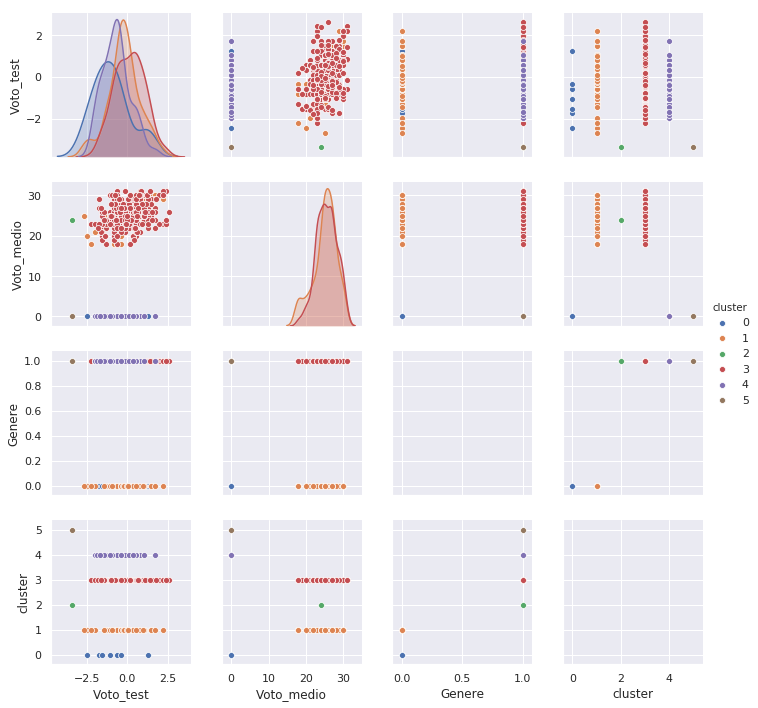

In [22]:
scatterMatrix1 = sns.pairplot(datasetHC1, hue="cluster")


In [23]:
groupByCluster1HC = datasetHC1.groupby("cluster").mean()
numStudenti = datasetHC1["cluster"].value_counts()

In [24]:
groupByCluster1HC

,Voto_test,Voto_medio,Genere
cluster,,,
0,-0.923239,0.000000,0
1,-0.176830,25.147541,0
2,-3.376116,24.000000,1
3,0.163619,25.570149,1
4,-0.641889,0.000000,1
5,-3.376116,0.000000,1


In [25]:
numStudenti

3    335
1     61
4     48
0      7
5      1
2      1
Name: cluster, dtype: int64

### Commento dei risultati ottenuti con clustering Average Link

> Il clustering ha restituito 6 gruppi di studenti.
Possiamo osservare che il cluster 3 è quello più grande e include tutti gli studenti maschi che hanno ottenuto un voto sopra la media nel test e hanno dato esami.
Il cluster 4 include gli studenti maschi che hanno ottenuto un voto basso al test e non hanno dato esami.
Il cluster 1 include la maggior parte delle studentesse, e hanno dato molti esami e ottenuto un voto medio nel test.
I cluster 0, 2 e 5 sono poco significativi, includendo solo 7 studentesse nel cluster 0 e uno studente negli altri due. In particolare il cluster 0 include studentesse che hanno ottenuto un voto basso nel test e non hanno dato esami. Il cluster 5 include uno studente che ha avuto il voto minimo al test, e non ha dato esami, mentre il cluster 2 include uno studente che ha avuto il voto minimo al test, ma ha dato esami.
Questi due cluster sono stati creati da singoli studenti poiché il loro voto al test è molto inferiore a qualunque altro studente.

### Clustering con il K-means

Il valore massimo del coefficiente di silhouette è  0.6069597126386307


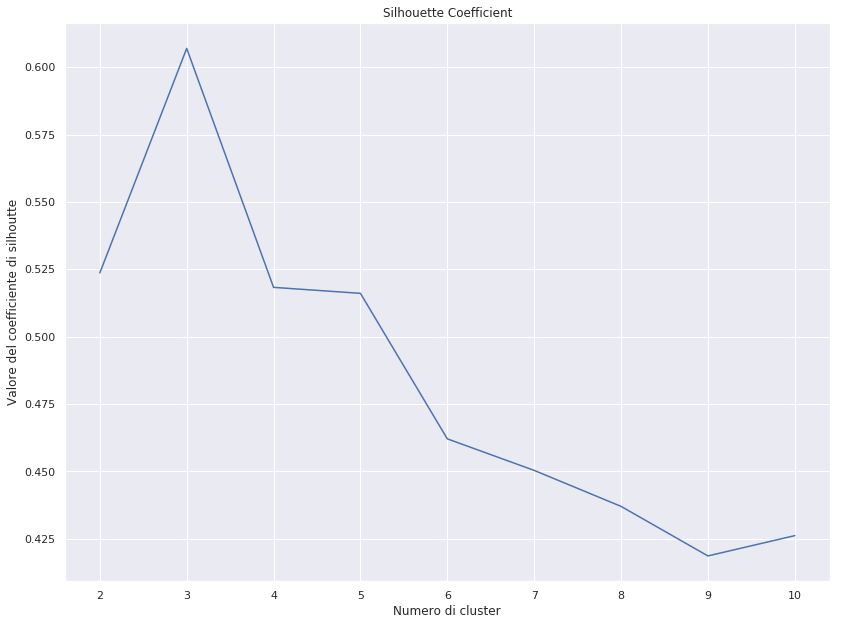

In [26]:
silhouette_Coefficient(dataset1, 11, "k-means++")

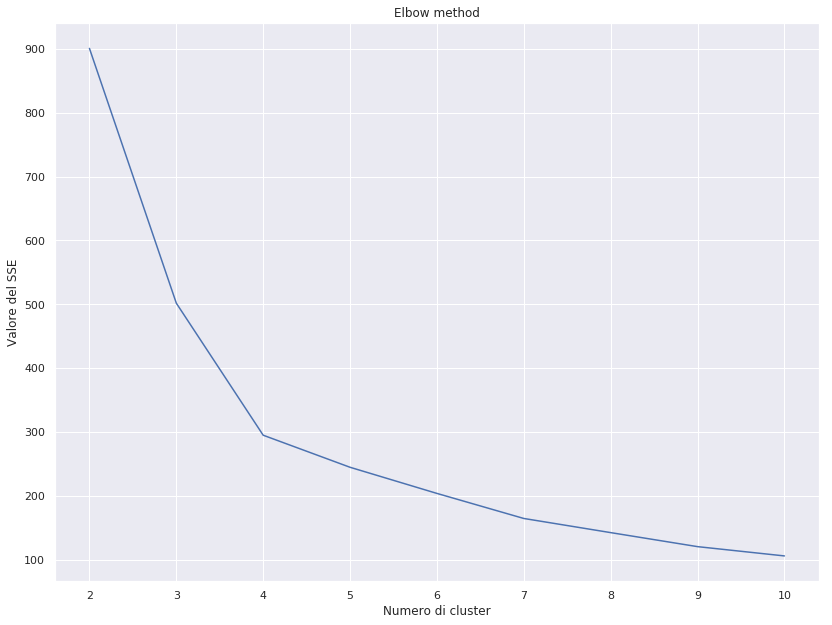

In [27]:
elbow_method(dataset1, 11, "k-means++")

## K=3

In [28]:
centroidsKmeans1, datasetStandarKmean1, datasetKmeans1 = kmeans(dataset1, 3,"k-means++")

clustering information:
 Valore SSE:  501.85896536671777 
 Numero di iterazioni 19 
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


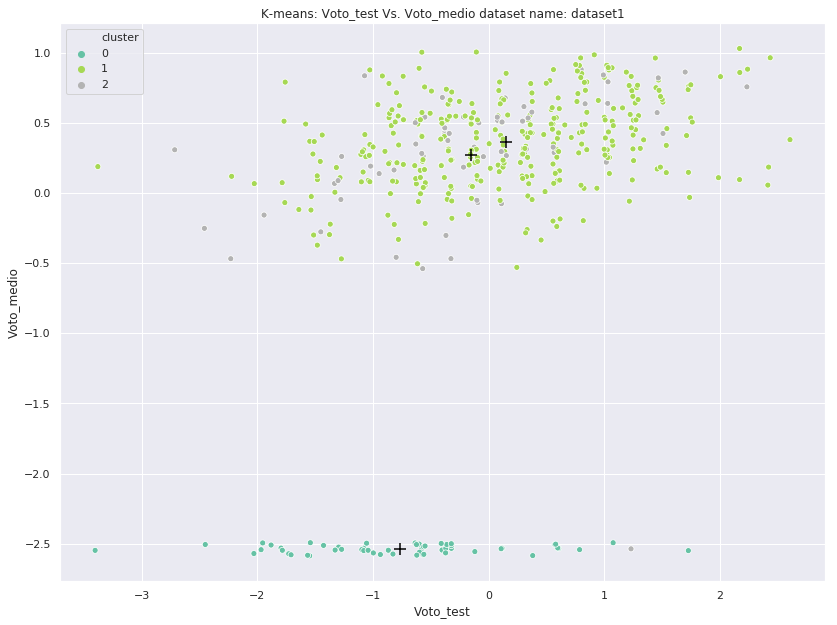

In [29]:
visDataKmeansJitter(datasetStandarKmean1, "Voto_test", "Voto_medio",centroidsKmeans1.Voto_test, centroidsKmeans1.Voto_medio, path1, "dataset1", jitter=0.5)

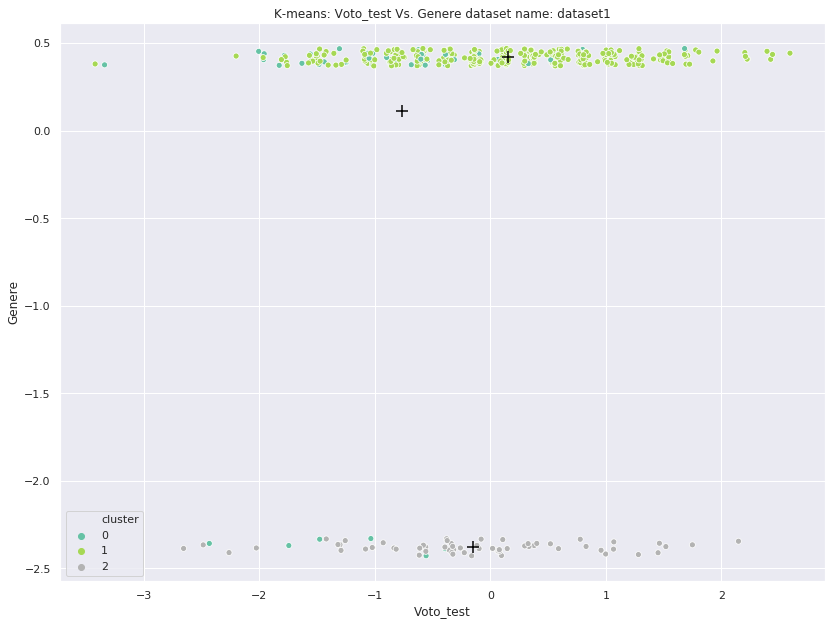

In [30]:
visDataKmeansJitter(datasetStandarKmean1, "Voto_test", "Genere",centroidsKmeans1.Voto_test, centroidsKmeans1.Genere, path1, "dataset1", jitter=0.5)

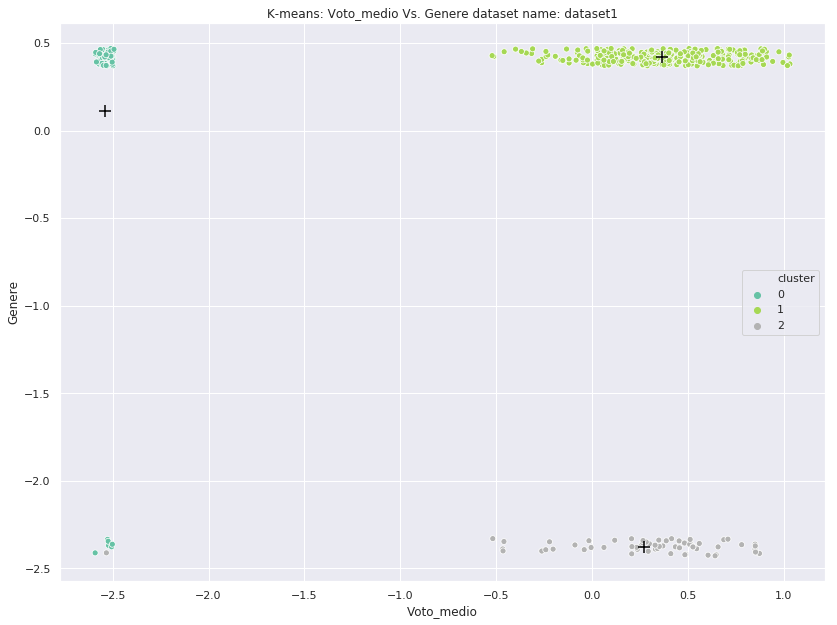

In [31]:
visDataKmeansJitter(datasetStandarKmean1, "Voto_medio", "Genere",centroidsKmeans1.Voto_medio, centroidsKmeans1.Genere, path1, "dataset1", jitter=0.5)

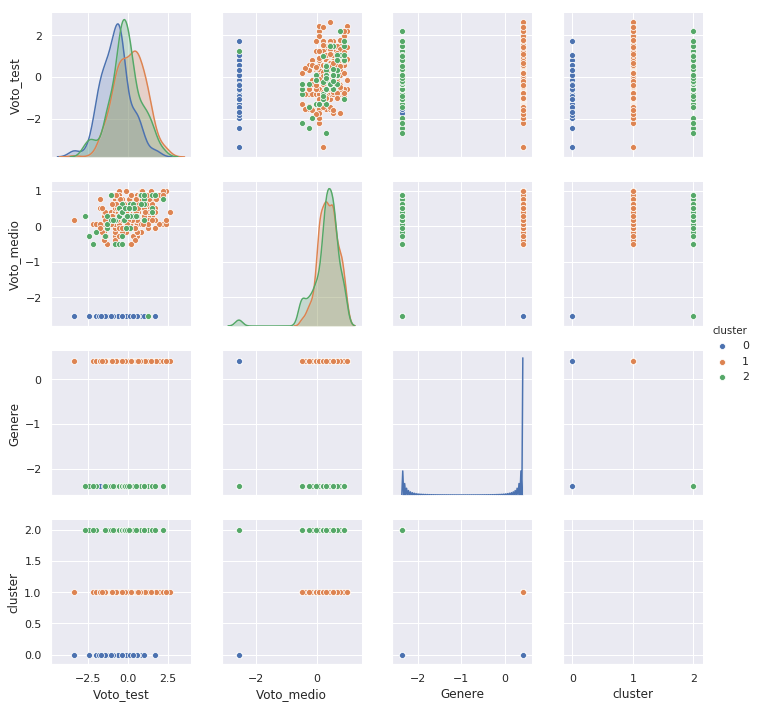

In [32]:
sns.pairplot(datasetStandarKmean1, hue="cluster")

In [33]:
#datasetKmeans1.head(20)

In [34]:
groupByClusterKmean1 = datasetKmeans1.groupby("cluster").mean()
numStudenti = datasetKmeans1["cluster"].value_counts()

In [35]:
groupByClusterKmean1

,Voto_test,Voto_medio,Genere
cluster,,,
0,-0.762072,0.000000,0.890909
1,0.153084,25.565476,1.000000
2,-0.153583,24.741935,0.000000


In [36]:
numStudenti

1    336
2     62
0     55
Name: cluster, dtype: int64

### Commento risultato con con k = 3

>Il clustering k-means con k=3 ha ottenuto un cluster composto da soli maschi (cluster 1), uno composto da sole femmine (cluster 2) e uno misto (cluster 0).
Osserviamo che il cluster 0 include tutti gli studenti e le studentesse che hanno ottenuto un voto basso al test e non hanno dato esami.
Tra gli studenti del cluster 1 il voto medio è circa 26 e il volto al test è leggermente sopra la media, mentre per le studentesse del cluster 2 il voto medio è circa 25 e il voto al test è leggermente sotto la media.

## k = 4

In [37]:
centroidsKmeans15, datasetStandarKmean15, datasetKmeans15 = kmeans(dataset1, 4,"k-means++")

clustering information:
 Valore SSE:  295.10028136720234 
 Numero di iterazioni 9 
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


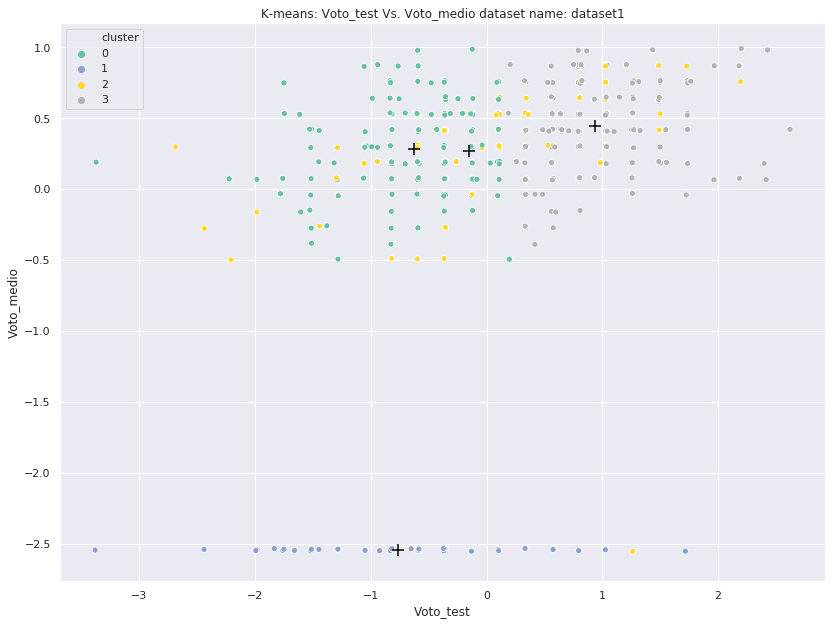

In [102]:
visDataKmeansJitter(datasetStandarKmean15, "Voto_test", "Voto_medio",centroidsKmeans15.Voto_test, centroidsKmeans15.Voto_medio, path1, "dataset1", jitter=0.1)

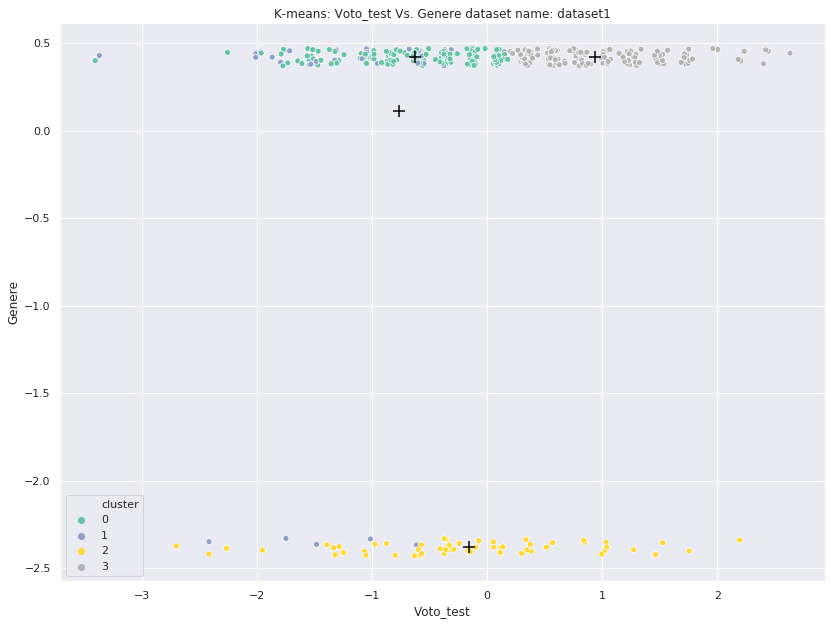

In [39]:
visDataKmeansJitter(datasetStandarKmean15, "Voto_test", "Genere",centroidsKmeans15.Voto_test, centroidsKmeans15.Genere, path1, "dataset1", jitter=0.5)

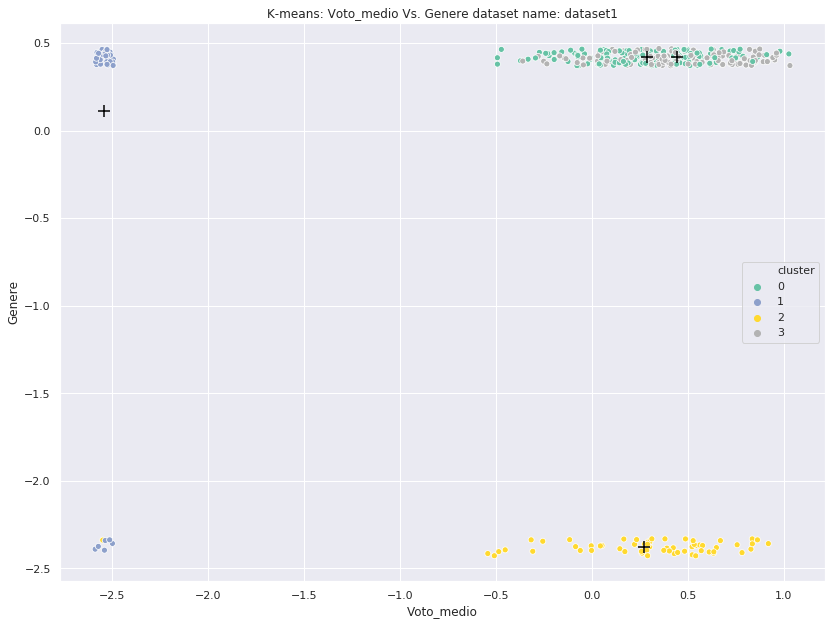

In [40]:
visDataKmeansJitter(datasetStandarKmean15, "Voto_medio", "Genere",centroidsKmeans15.Voto_medio, centroidsKmeans15.Genere, path1, "dataset1", jitter=0.5)

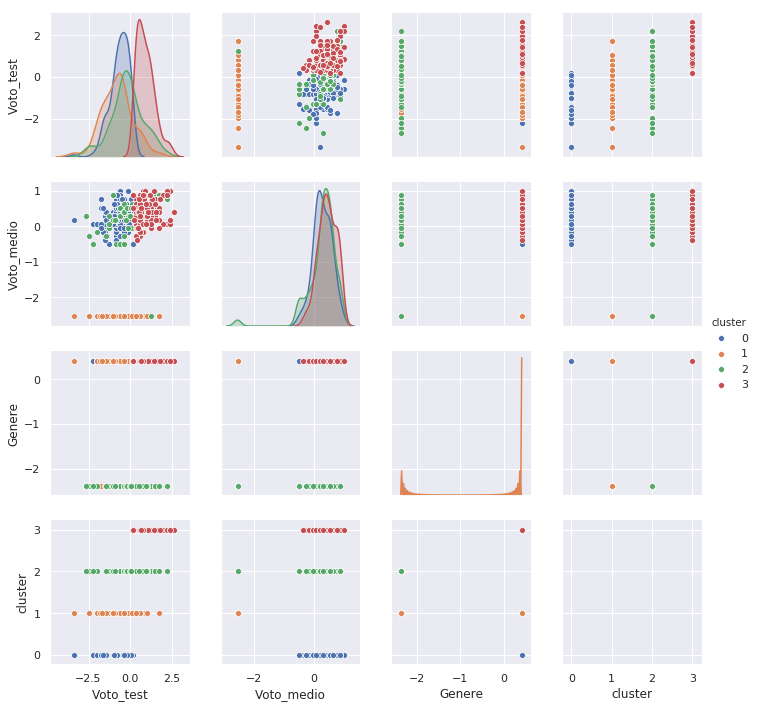

In [41]:
sns.pairplot(datasetStandarKmean15, hue="cluster")

In [42]:
groupByClusterKmeans15 = datasetKmeans15.groupby("cluster").mean()
numStudenti = datasetKmeans15["cluster"].value_counts()
groupByClusterKmeans15

,Voto_test,Voto_medio,Genere
cluster,,,
0,-0.622683,24.869822,1.000000
1,-0.762072,0.000000,0.890909
2,-0.153583,24.741935,0.000000
3,0.938141,26.269461,1.000000


In [43]:
numStudenti

0    169
3    167
2     62
1     55
Name: cluster, dtype: int64

### Commento risultato con k=4

>Il clustering k-means con k=4 ha ottenuto dei cluster simili a quelliper k=4. Anche in questo caso ha ottenuto un cluster composto da tutti gli studenti e le studentesse che hanno ottenuto un voto basso al test e non hanno dato esami (cluster 1) e un cluster composto da tutte le studentesse che hanno dato esami (cluster 2).
Gli studenti maschi che hanno dato esami sono stati divisi in due cluster, uno contenente gli studenti con un voto al test e un voto medio più basso (cluster 0) e uno contenente gli studenti con un voto al test e un voto medio più alto (cluster 3).

### Clustering con DBScan

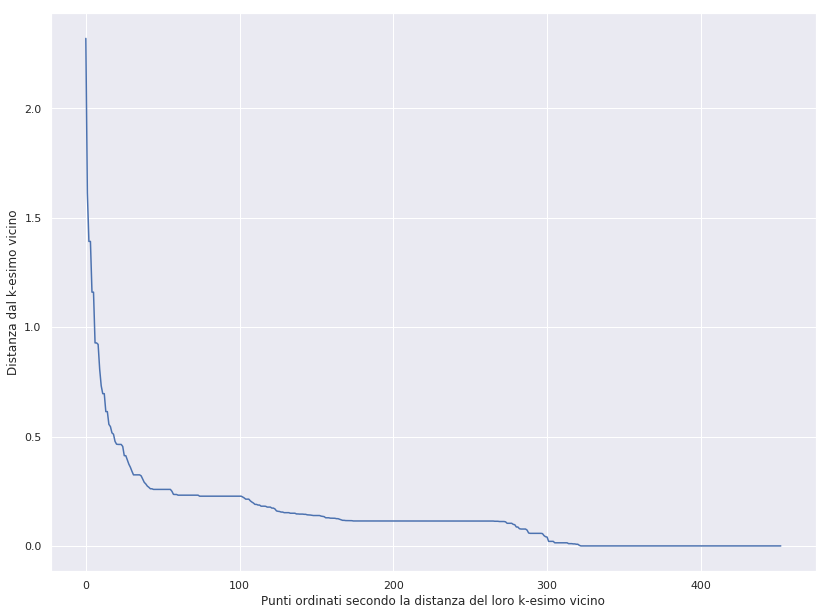

In [44]:
findParamerDBScan(dataset1,k_neighbors=4)

In [45]:
datasetStandarDBSCAN1, datasetDBscan1 = dbScan(dataset1, 0.25, 4)

clustering information  DBSCAN(algorithm='auto', eps=0.25, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=4, n_jobs=None, p=None)


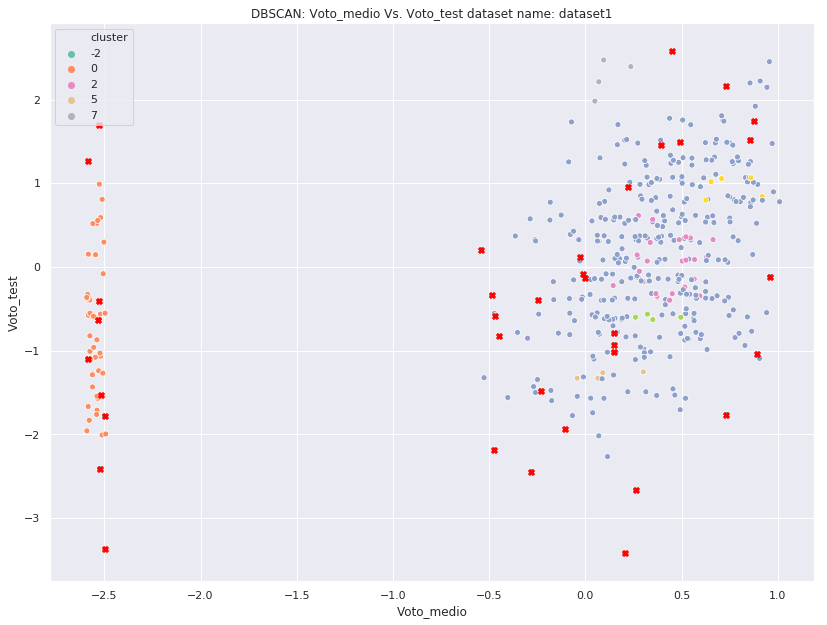

In [46]:
#dataVizDBscan(tempory_ds,"Voto_medio", "Voto_test")
dataVisClusteringJitter(datasetStandarDBSCAN1,"Voto_medio", "Voto_test", path2, "dataset1",clusteringName="dbscan", jitter=0.5)

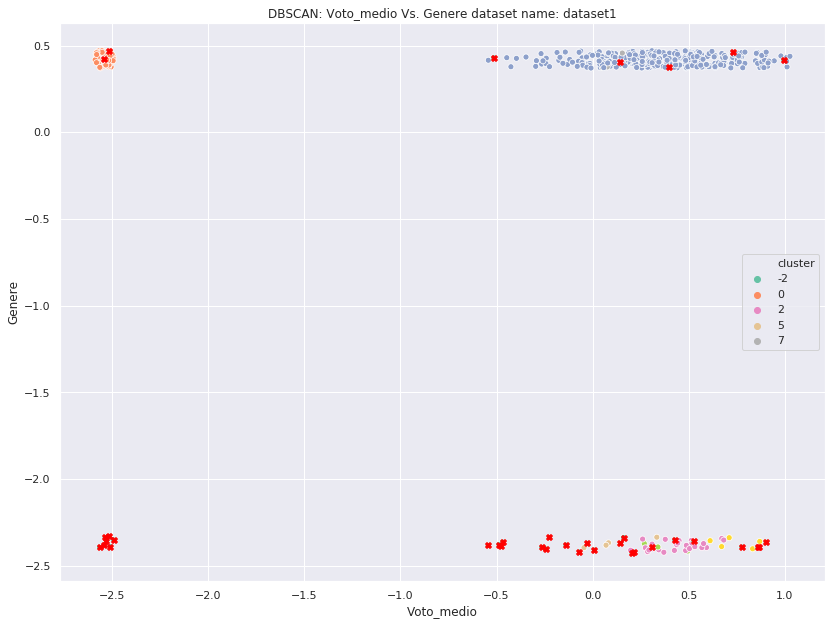

In [47]:
dataVisClusteringJitter(datasetStandarDBSCAN1,"Voto_medio", "Genere", path2, "dataset1",clusteringName="dbscan", jitter=0.5)

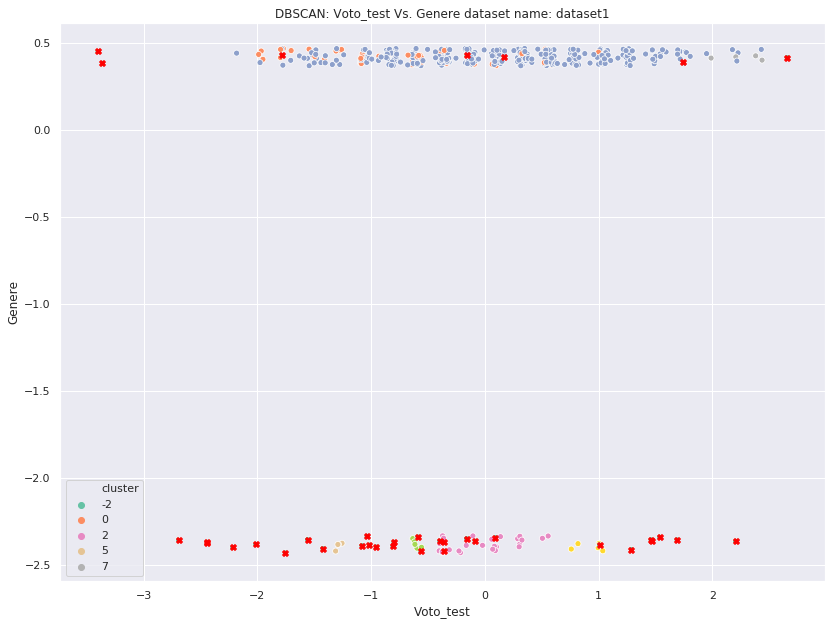

In [48]:
dataVisClusteringJitter(datasetStandarDBSCAN1,"Voto_test", "Genere", path2, "dataset1",clusteringName="dbscan", jitter=0.5)

### Commento dei risultati trovati con il DBSCAN

In [49]:
groupByClusterDBScan = datasetDBscan1.groupby("cluster").mean()
numStudenti = datasetDBscan1["cluster"].value_counts()

In [50]:
groupByClusterDBScan

,Voto_test,Voto_medio,Genere
cluster,,,
-1,-0.502244,17.777778,0.194444
0,-0.692323,0.000000,1.000000
1,0.137334,25.593272,1.000000
2,0.006133,26.200000,0.000000
3,-0.591769,25.800000,0.000000
4,0.939622,29.000000,0.000000
5,-1.287856,23.250000,0.000000
6,2.242658,23.250000,1.000000


In [51]:
numStudenti

 1    327
 0     47
-1     36
 2     25
 4      5
 3      5
 6      4
 5      4
Name: cluster, dtype: int64

### Commento risultati ottenuti dal clustering DBSCAN

>Il clustering DBSCAN ha ottenuto 7 cluster, tuttavia solo i cluster 0, 1 e 2 sono abbastanza grandi da essere significativi.
Il cluster 1 include studenti maschi che hanno sostenuto esami, il cluster 0 include studenti maschi che non hanno dato esami, mentre il cluster 2 include la maggior parte delle studentesse.
I cluster minori includono complessivamente 18 studenti, principalemente femmine con voti alti agli esami.
36 elementi sono stati considerati rumore.
In questo caso notiamo che gli studenti del cluster 1 hanno un voto al test leggermente sopra la media e un voto medio di circa 26, mentre le studentesse del cluster 2 hanno un voto al test medio e hanno un voto medio di circa 26.

### Commento generale sui risultati ottenuti dal clustering

>Tutti gli algoritmi di clustering analizzati hanno identificato tre gruppi di studenti: quelli con un pessimo voto al test e senza esami, poi gli studenti maschi con una buona carriera e le studentesse con una buona carriera.
Abbiamo notato anche che entrambi i valori dei voti sono mediamente molto simili tra maschi e femmine con una carriera significativa.

## Analisi dei dati con soli esami

In [52]:
path1 = './clustering/votiCluster/kmeans'
path2 = './clustering/votiCluster/dbscan'
path3 = './clustering/votiCluster/gerarchico'
dataset2 = dataset[["ASD","ARC","PRG", "AN1", "MDL"]]

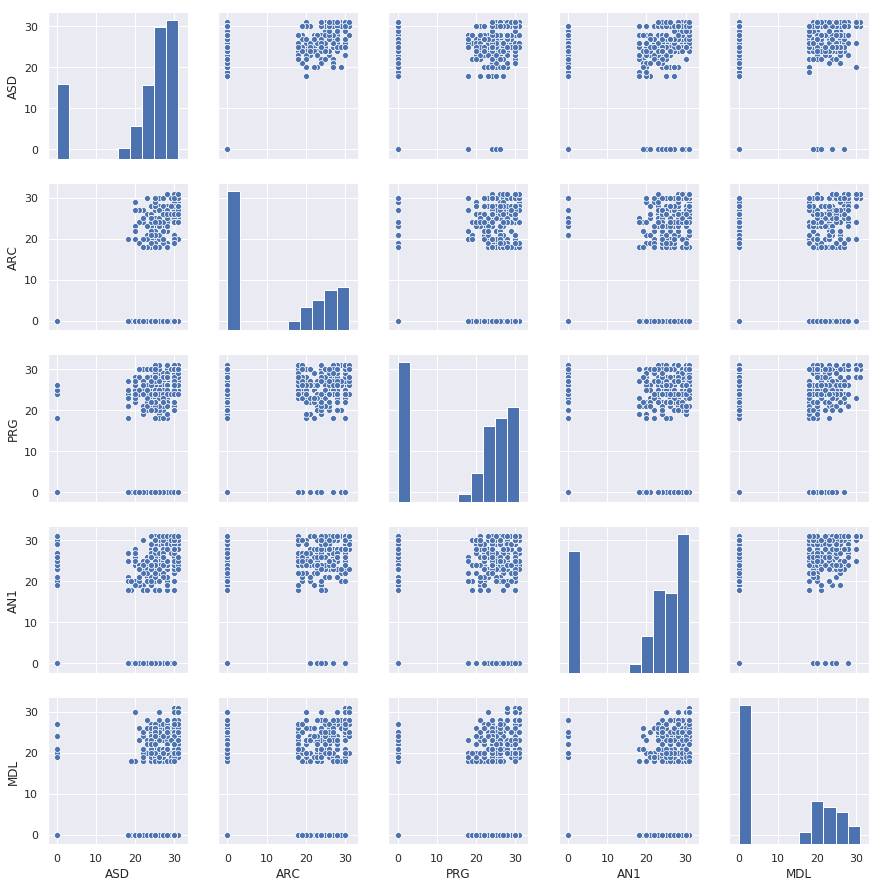

In [53]:
sns.pairplot(dataset2)

### Clustering gerachico

Il valore del coefficiente  di correlazione di CoPhenetic per clustering gerarchico con il metodo  average  è  0.8601503440325848
Clustering information:  AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=5, pooling_func='deprecated')


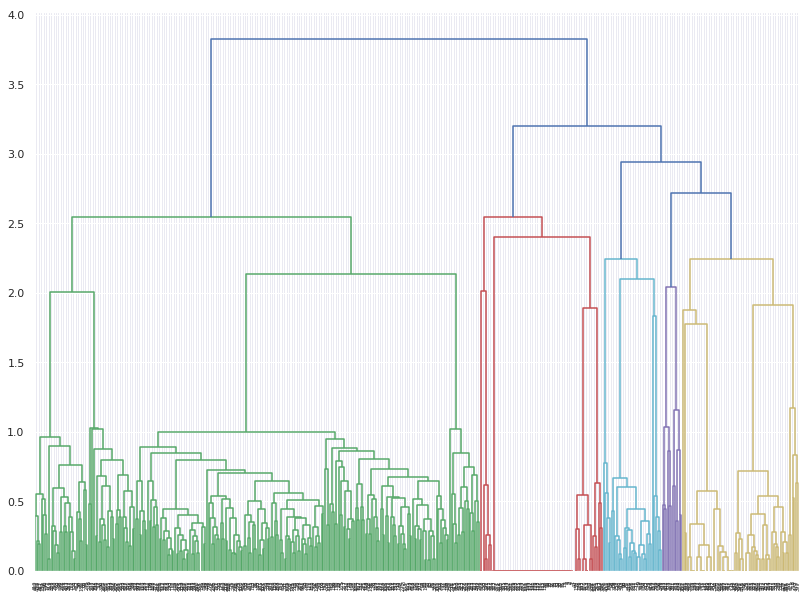

In [54]:
c_hierarchic_scipy(dataset2, "average",fs=(30,23))
datasetStandarHC2, datasetHC2 = c_hierarchic_Sklearn(dataset2, 5, "average")

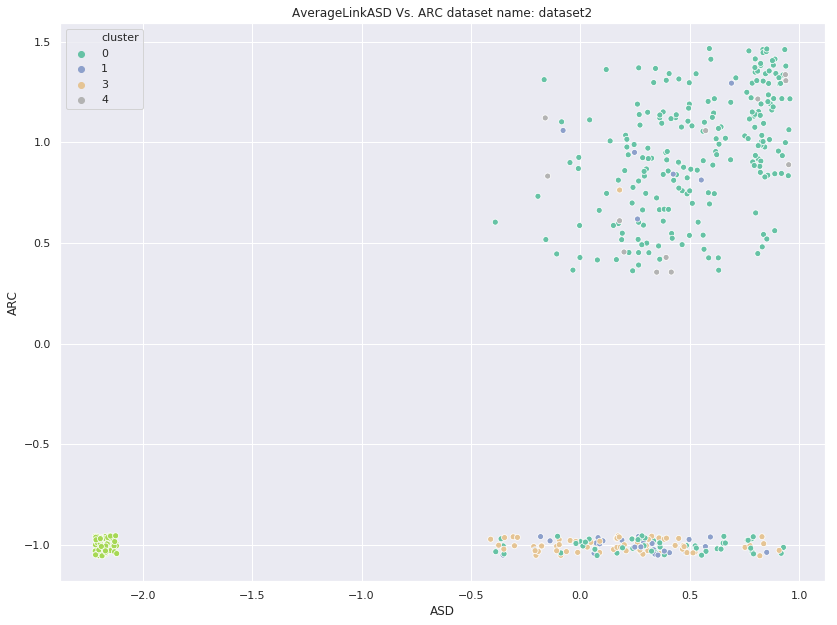

In [55]:
dataVisClusteringJitter(datasetStandarHC2, "ASD", "ARC", path3, "dataset2",clusteringName="AverageLink", jitter=0.5)

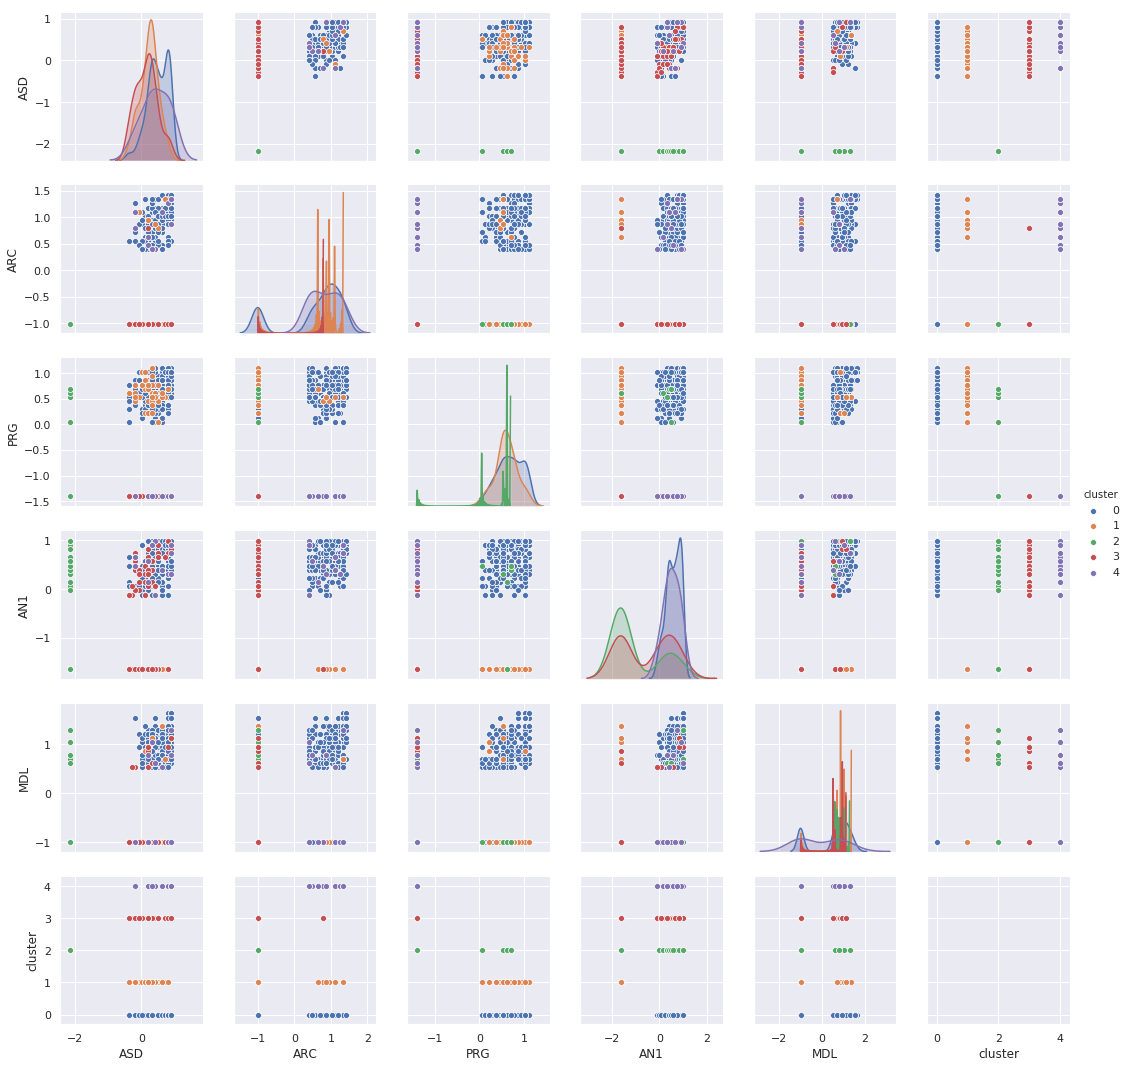

In [56]:
scatterMatrix = sns.pairplot(datasetStandarHC2, hue="cluster")
scatterMatrix.savefig("./scatterMatrixHC2.png")

In [57]:
groupByClusterHC2 = datasetHC2.groupby("cluster").mean()
numStudenti = datasetHC2["cluster"].value_counts()

In [58]:
groupByClusterHC2

,ASD,ARC,PRG,AN1,MDL
cluster,,,,,
0,26.924242,20.325758,25.867424,26.405303,17.992424
1,24.285714,4.285714,24.885714,0.000000,4.028571
2,0.000000,0.000000,2.315068,7.589041,1.780822
3,23.478261,0.333333,0.000000,13.275362,2.405797
4,26.333333,23.666667,0.000000,25.500000,10.833333


In [59]:
numStudenti

0    264
2     73
3     69
1     35
4     12
Name: cluster, dtype: int64

In [60]:
datasetClassification = dataset[["Genere", "Scuola_provenienza","Coorte","Voto_test"]]
datasetClassification["cluster"] = datasetHC2["cluster"]
datasetClassification.to_csv(path_or_buf="../data/interim/datasetClassification.csv", index=False)


# Commento sui risultati trovati con il metodo Average Link

>Questo risultato è molto interessante perchè abbiamo 5 gruppi di studenti dove:
>Il cluster 0 contiene studenti che hanno dato la maggior parte degli esami, e rappresenta il gruppo più grande, essendo 264 studenti.
Il cluster 1 contiene studenti che hanno dato priorità all'esame di Algoritmi e Strutture Dati e a quello di Programmazione, ma generalmente non hanno dato gli altri esami, che hanno mediamente valore vicino a zero.
Il cluster 2 contiene studenti che non hanno dato esami, salvo poche eccezioni.
Il cluster 3 contiene studenti che hanno dato priorità all'esame di algoritmi e in alcuni casi quello di Analisi 1, trascurando gli altri esami.
Il cluster 4 contiene studenti che hanno dato ASD, Architetture e Analisi, ma hanno generalmente trascurato Programmazione e MDL.

>Possiamo notare che in tutti i cluster tranne il 2, l'esame di Algoritmi è quello a cui la maggior parte degli studenti dà priorità. L'esame di MDL è invece quello che la maggior parte degli studenti non svolge entro il primo anno, avendo un valore medio inferiore a 18 in tutti i cluster.

# Clustering con il K-means

Il valore massimo del coefficiente di silhouette è  0.5972164202189325


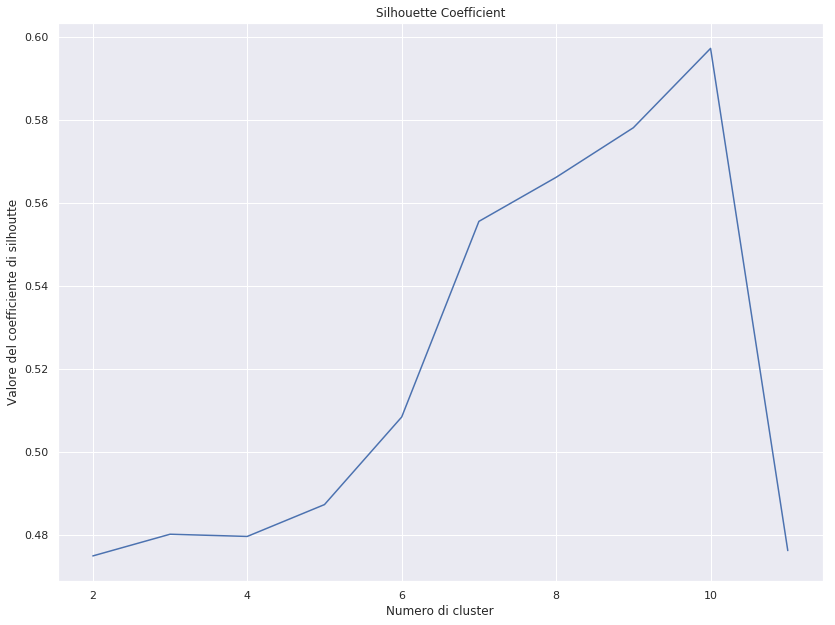

In [61]:
silhouette_Coefficient(dataset2, 12, "k-means++")

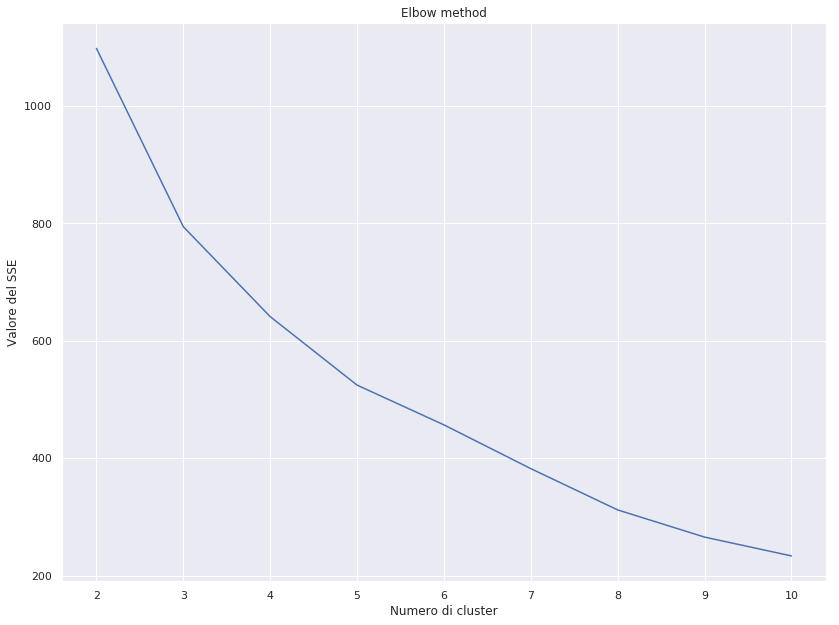

In [62]:
elbow_method(dataset2,11,"k-means++")

## K=10

In [63]:
centroidsKmeans2, datasetStandarKmean2, datasetKmeans2 = kmeans(dataset2, 10,"k-means++")

clustering information:
 Valore SSE:  233.53420011213072 
 Numero di iterazioni 5 
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


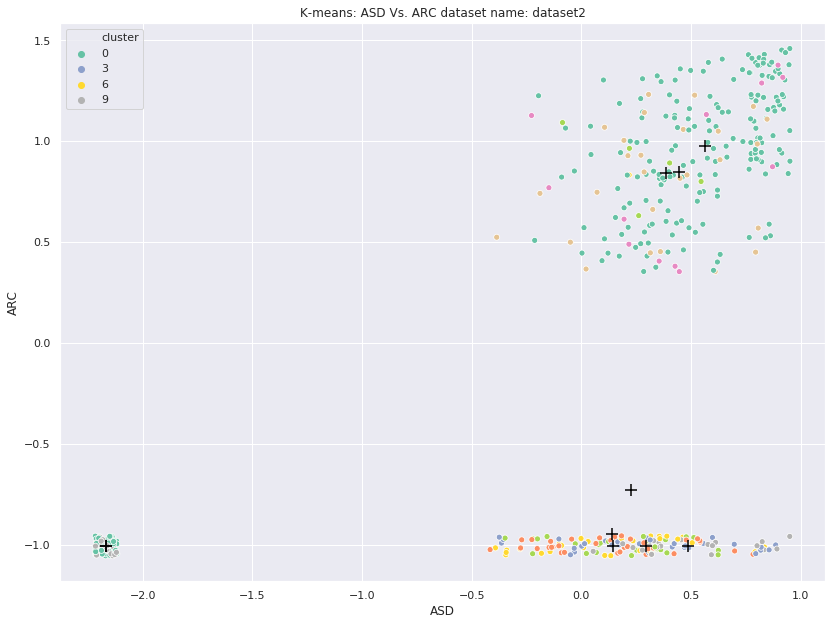

In [64]:
visDataKmeansJitter(datasetStandarKmean2, "ASD", "ARC",centroidsKmeans2.ASD, centroidsKmeans2.ARC, path1, "dataset2", jitter=0.5)

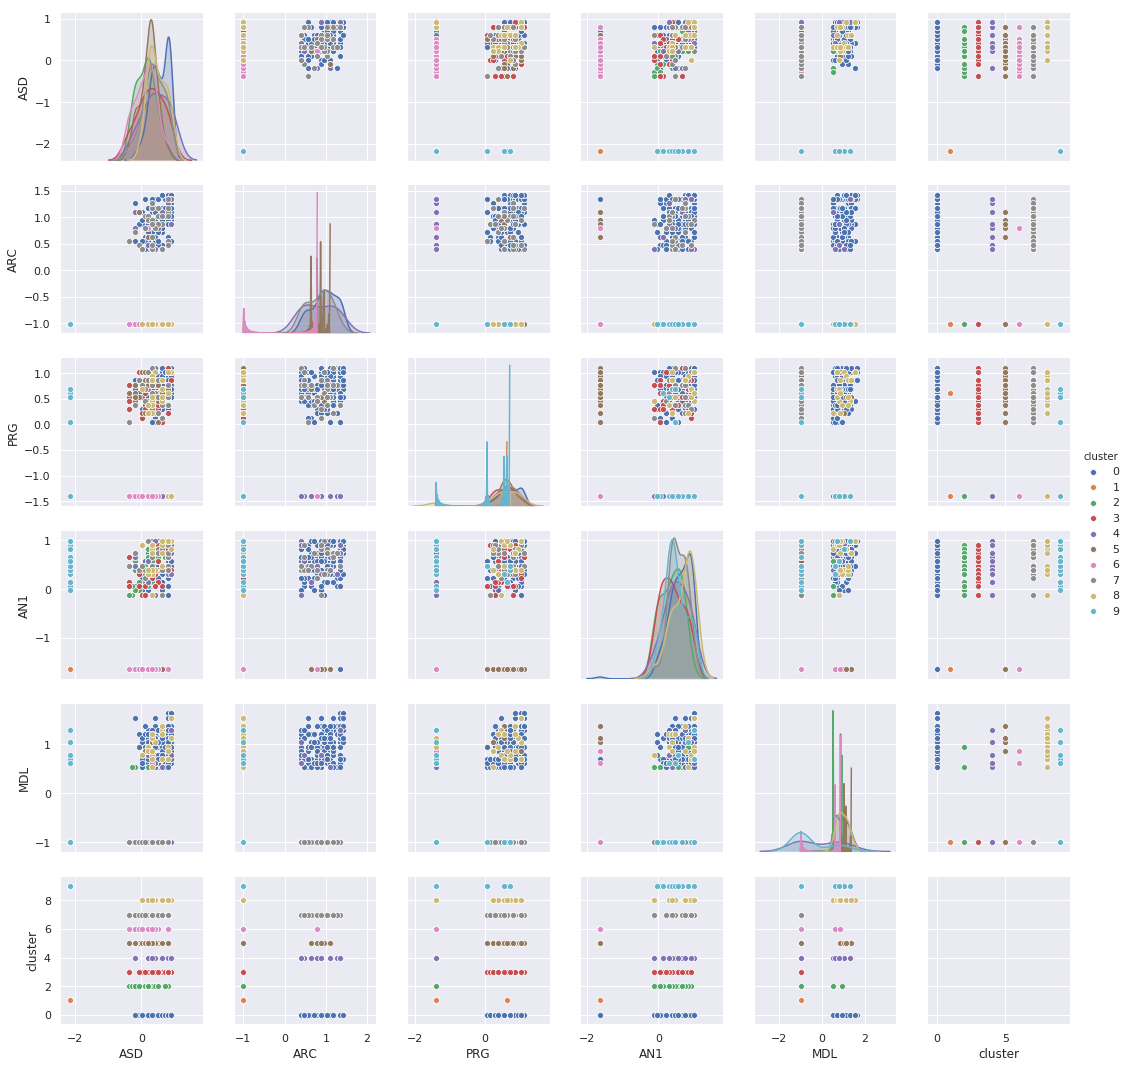

In [65]:
sns.pairplot(datasetStandarKmean2, hue="cluster")

In [66]:
groupByClusterKmeans2 = datasetKmeans2.groupby("cluster").mean()
numStudenti = datasetKmeans2["cluster"].value_counts()

In [67]:
groupByClusterKmeans2

,ASD,ARC,PRG,AN1,MDL
cluster,,,,,
0,27.529412,25.315508,26.213904,26.668449,23.256684
1,0.000000,0.000000,0.980392,0.000000,0.000000
2,23.277778,0.000000,0.000000,23.777778,2.138889
3,24.812500,0.000000,24.593750,24.031250,0.000000
4,26.333333,23.666667,0.000000,25.500000,10.833333
5,24.147059,3.529412,24.911765,0.000000,3.558824
6,23.258065,0.741935,0.000000,0.000000,1.322581
7,25.750000,23.642857,25.214286,25.928571,0.000000
8,26.750000,0.000000,22.900000,27.450000,23.450000


In [68]:
numStudenti

0    187
1     51
2     36
5     34
3     32
6     31
7     28
9     22
8     20
4     12
Name: cluster, dtype: int64

# Commmento del risultato ottenuto con il K-means

>Il clustering K-Means con K=10 ha definito vari profili di studenti.
Il cluster 0 è quello più grande, includendo 187 studenti, ed include coloro che hanno dato la maggior parte degli esami.
Il secondo cluster più grande è il cluster 1, che include 51 studenti e sono coloro che non hanno dato alcun esame.
Gli altri cluster individuano altri gruppi di studenti che hanno svolto specifici gruppi di esami, e possiamo notare che nella maggior parte dei casi è presente l'esame di ASD, mentre è assente l'esame di MDL; le uniche eccezioni sono il cluster 8, che include studenti che hanno dato tutti gli esami tranne Architetture, e il cluster 9, che include studenti che hanno dato solo Analisi 1.

# Clustering con DBSCAN

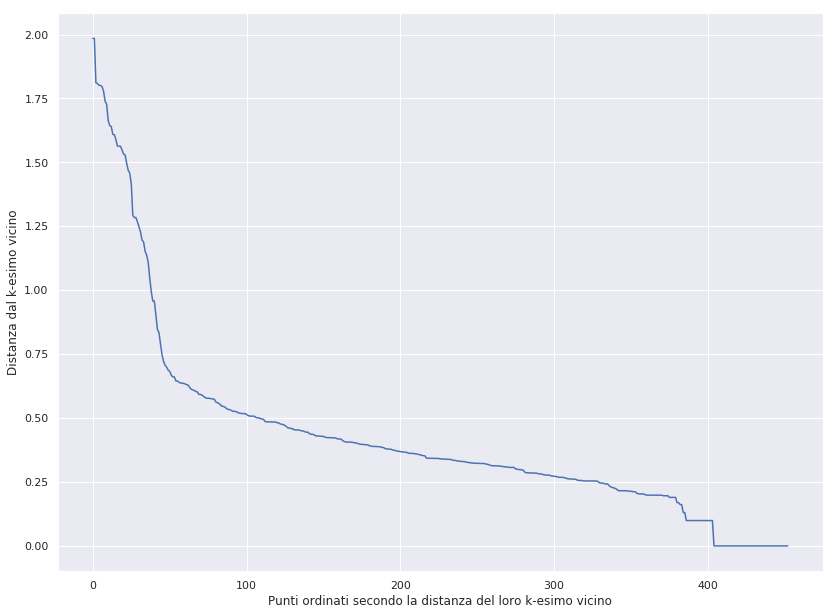

In [69]:
findParamerDBScan(dataset2,k_neighbors=6)

In [70]:
datasetStandarDBSCAN2, datasetDBscan2 = dbScan(dataset2, 0.625, 6)

clustering information  DBSCAN(algorithm='auto', eps=0.625, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=6, n_jobs=None, p=None)


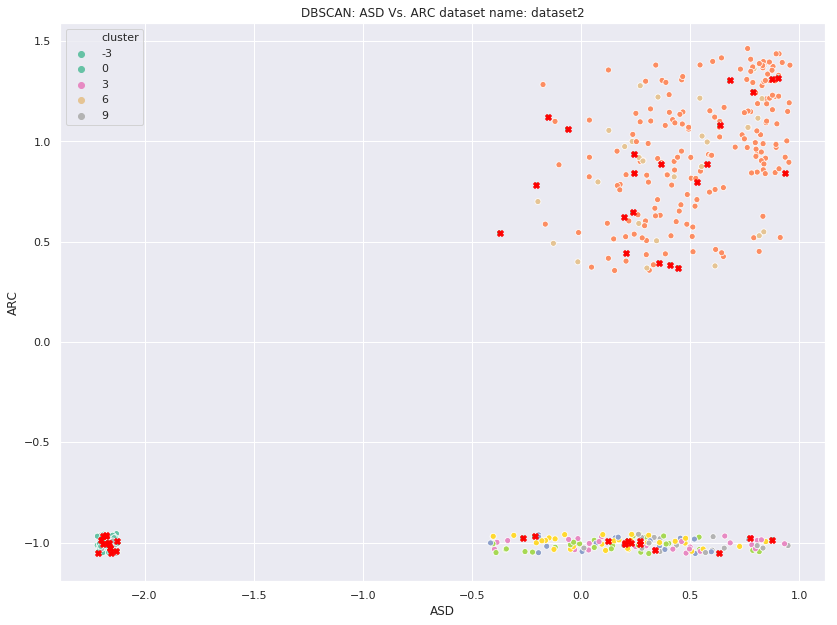

In [71]:
dataVisClusteringJitter(datasetStandarDBSCAN2,"ASD", "ARC", path2, "dataset2",clusteringName="dbscan", jitter=0.5)

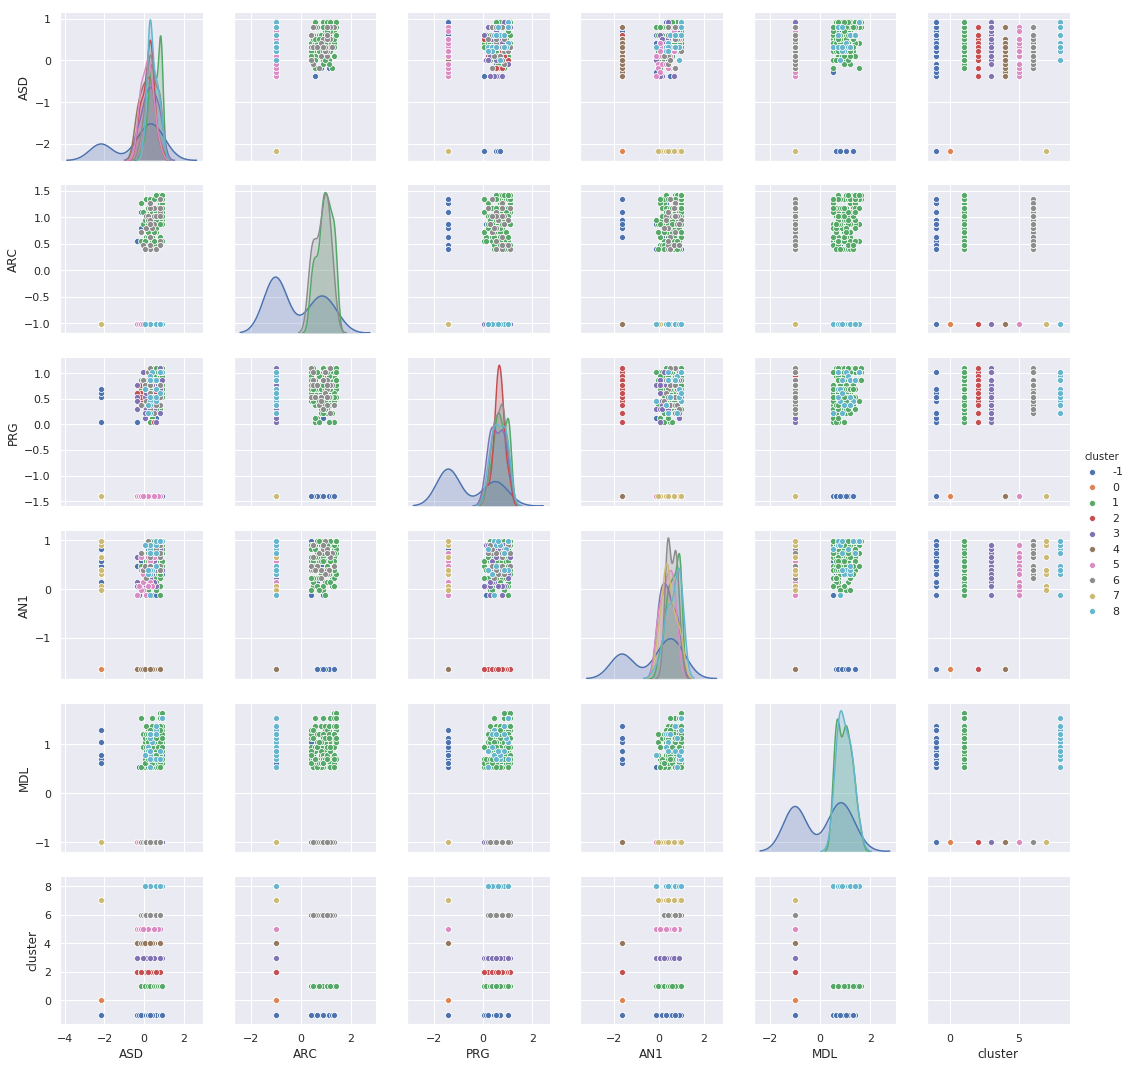

In [72]:
sns.pairplot(datasetStandarDBSCAN2, hue="cluster")

In [73]:
groupByClusterDBScan2 = datasetDBscan2.groupby("cluster").mean()
numStudenti = datasetDBscan2["cluster"].value_counts()

In [74]:
groupByClusterDBScan2

,ASD,ARC,PRG,AN1,MDL
cluster,,,,,
-1,18.276596,10.659574,9.957447,16.702128,12.063830
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,27.521505,25.290323,26.225806,26.811828,23.274194
2,23.916667,0.000000,25.375000,0.000000,0.000000
3,24.812500,0.000000,24.593750,24.031250,0.000000
4,23.142857,0.000000,0.000000,0.000000,0.000000
5,23.468750,0.000000,0.000000,23.843750,0.000000
6,25.961538,23.769231,25.730769,26.269231,0.000000
7,0.000000,0.000000,0.000000,24.636364,0.000000


In [75]:
numStudenti

 1    186
 0     49
-1     47
 5     32
 3     32
 4     28
 6     26
 2     24
 8     18
 7     11
Name: cluster, dtype: int64

# Commento dei risultati ottentuti con il DBSCAN

>Il clustering DBSCAN ha individuato 9 cluster molto simili a quelli individuati dal K-Means.
Anche questa volta il cluster più grande è quello degli studenti che hanno svolto tutti gli esami (cluster 1), e include 186 studenti, mentre il secondo cluster più grande è quello degli studenti che non hanno dato alcun esame (cluster 0), e include 49 studenti.
I cluster 2, 3, 4, 5 e 6 includono studenti che hanno svolto l'esame di ASD, ma non quello di MDL, e ciascun cluster include varie combinazioni degli altri esami.
Il cluster 7 include gli studenti che hanno dato solo Analisi, somigliando quindi al cluster 9 del K-Means, mentre il cluster 8 include gli studenti che hanno dato tutti gli esami tranne Architetture, somigliando quindi al cluster 8 del K-Means.

# Commento generale sui risultati ottenuti

>Tutti i metodi di clustering analizzati hanno messo in evidenza come l'esame di Algoritmi e Strutture dati sia quello a cui la maggior parte degli studenti ha dato priorità, mentre l'esame di MDL è quello a cui viene data una priorità minore.
Riguardo gli altri esami abbiamo potuto osservare vari pattern tra gli studenti, ma generalmente viene data una priorità maggiore a Programmazione e Analisi piuttosto che Architetture.

### Analisi dei dati con scuola di provenienza, voto test e voto medio, analisi 1 e programmazione

In [76]:
path1 = './clustering/analisi/kmeans'
path2 = './clustering/analisi/dbscan'
path3 = './clustering/analisi/gerachico'

In [77]:
dataset3 = dataset[["AN1", "PRG","Voto_test","Scuola_provenienza"]]

## Analisi con il clustering gerarchico

Il valore del coefficiente  di correlazione di CoPhenetic per clustering gerarchico con il metodo  average  è  0.7974300698905452
Clustering information:  AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=6, pooling_func='deprecated')


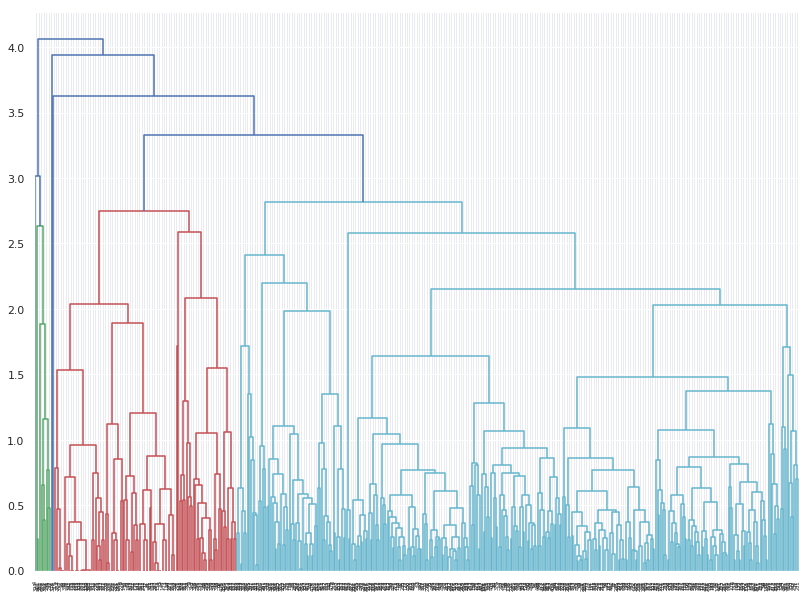

In [78]:
c_hierarchic_scipy(dataset3, "average",fs=(30,23))
datasetStandarHC3, datasetHC3 = c_hierarchic_Sklearn(dataset3, 6, "average")

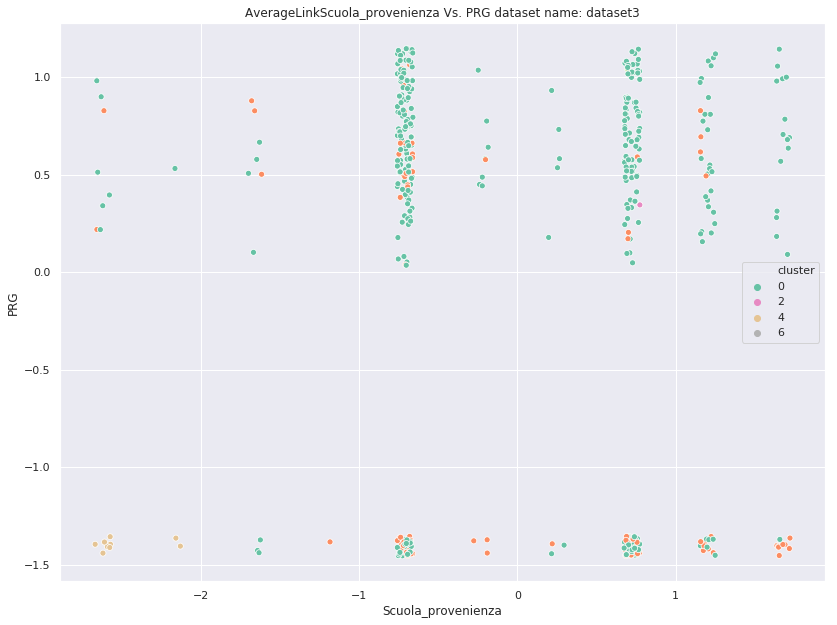

In [79]:
dataVisClusteringJitter(datasetStandarHC3, "Scuola_provenienza", "PRG", path3, "dataset3",clusteringName="AverageLink", jitter=0.5)

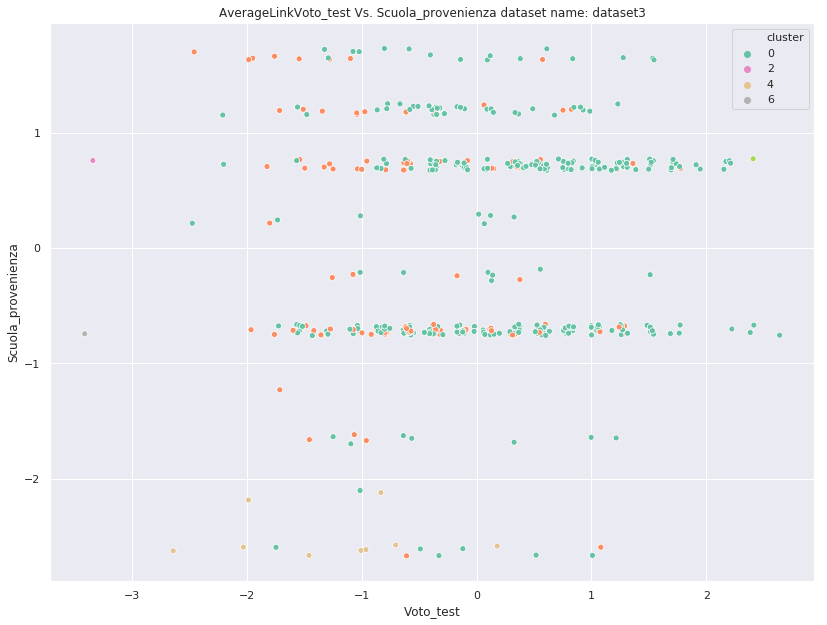

In [80]:
dataVisClusteringJitter(datasetStandarHC3, "Voto_test", "Scuola_provenienza", path3, "dataset3",clusteringName="AverageLink", jitter=0.5)

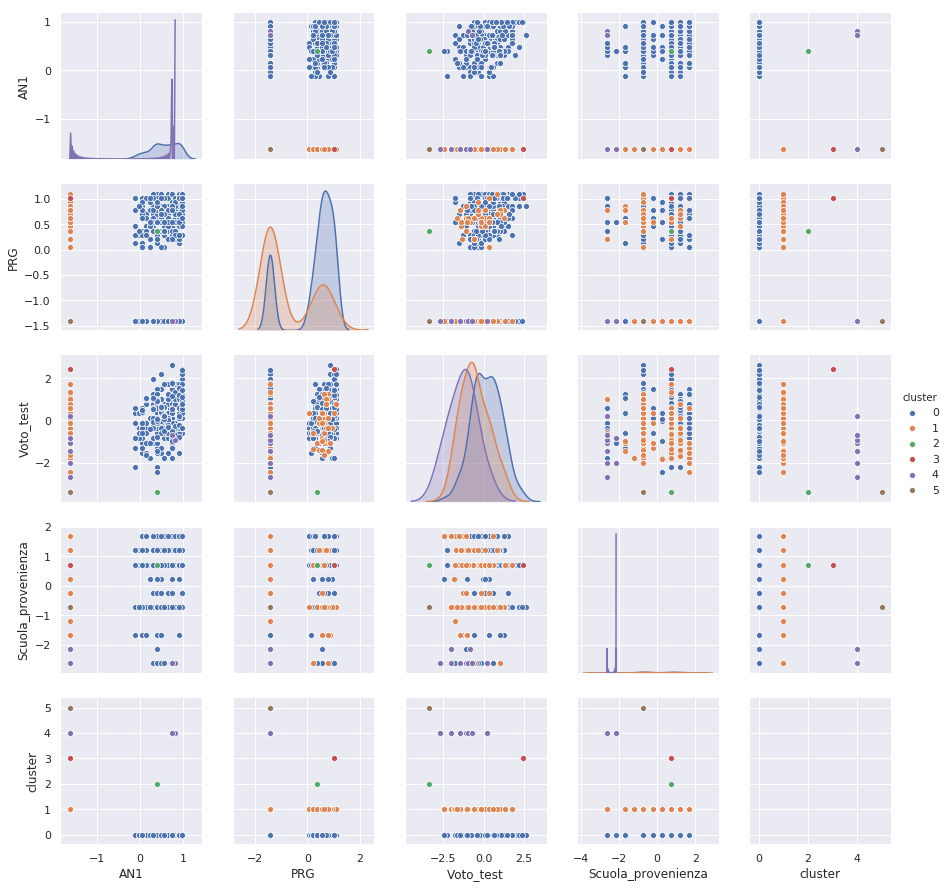

In [81]:
sns.pairplot(datasetStandarHC3, hue="cluster")

In [82]:
groupByClusterHC3 = datasetHC3[["AN1","PRG","Voto_test","cluster"]].groupby("cluster").mean()
sc= datasetHC3[["Scuola_provenienza","cluster"]].groupby("cluster").apply(pd.DataFrame.mode).reset_index(drop=True).drop("cluster",axis=1)
groupByClusterHC3["Scuola_provenienza"] = sc
numStudenti4 = datasetHC3["cluster"].value_counts()

In [83]:
groupByClusterHC3

,AN1,PRG,Voto_test,Scuola_provenienza
cluster,,,,
0,26.024024,20.798799,0.211120,4
1,0.000000,8.250000,-0.505209,4
2,24.000000,22.000000,-3.376116,7
3,0.000000,30.000000,2.424608,7
4,6.333333,0.000000,-1.268072,0
5,0.000000,0.000000,-3.376116,4


In [84]:
numStudenti4

0    333
1    108
4      9
5      1
3      1
2      1
Name: cluster, dtype: int64

### Commento dei risultati ottentuti con clustering gerarchico

>Il clustering gerarchico ha individuato 6 cluster, ma solo due includono un numero significativo di studenti.
Il cluster 0 include 333 studenti, e sono coloro che hanno svolto entrambi gli esami.
Il cluster 1 include 108 studenti, e sono coloro che non hanno dato i due esami.
In entrambi i casi la moda della variabile scuola_provenienza è 4, ovvero IT.
Il cluster 4 include solo 9 studenti, che in questo non hanno svolto esami, hanno ottenuto un voto basso al test e provengono soprattutto dalla scuola AL.
I tre cluster rimanenti includono uno studente ciascuno, quindi rappresentano anomalie.

## Analisi con l'algoritmo kmeans

Il valore massimo del coefficiente di silhouette è  0.37499862358950153


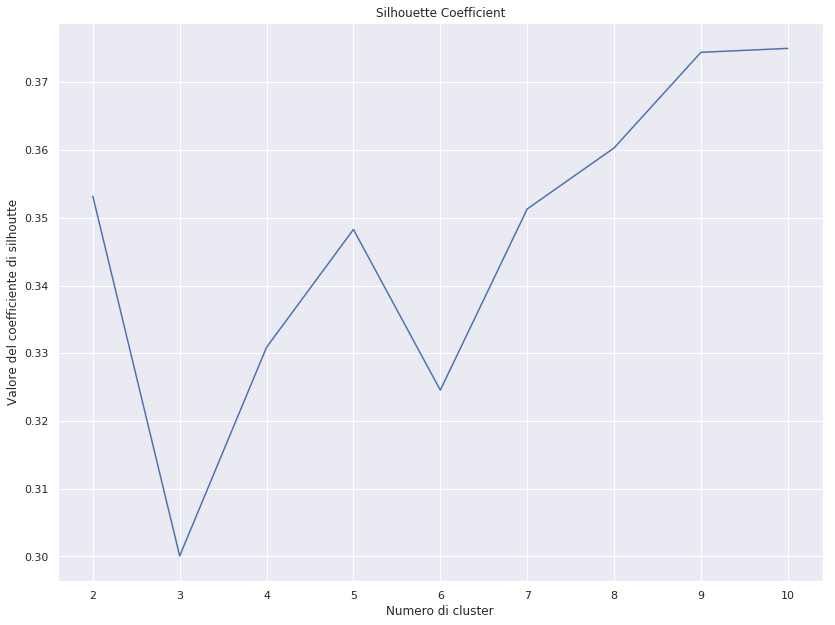

In [85]:
silhouette_Coefficient(dataset3, 11, "k-means++")

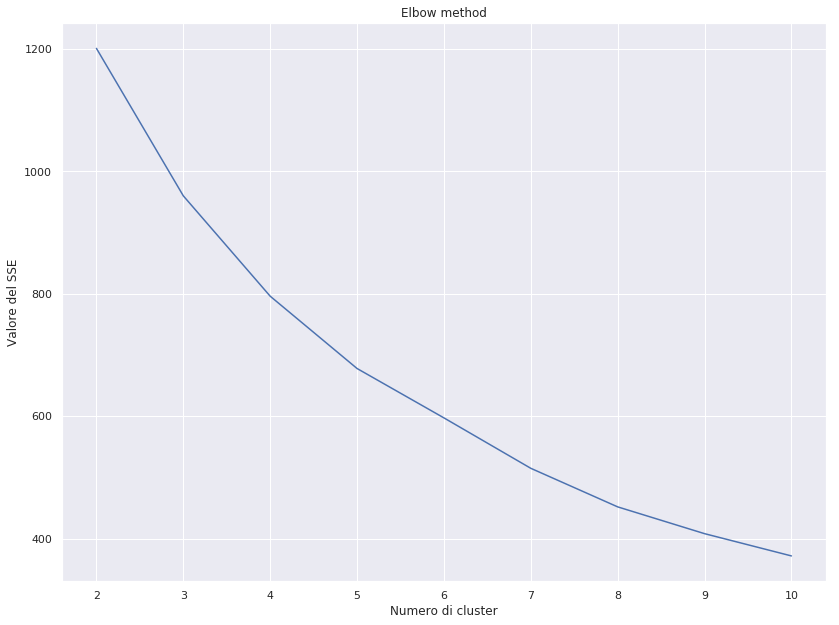

In [86]:
elbow_method(dataset3, 11, "k-means++")

In [87]:
centroids3, datasetStandarKmean3, datasetKmeans3 = kmeans(dataset3, 9,"k-means++")

clustering information:
 Valore SSE:  408.1605560338137 
 Numero di iterazioni 8 
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


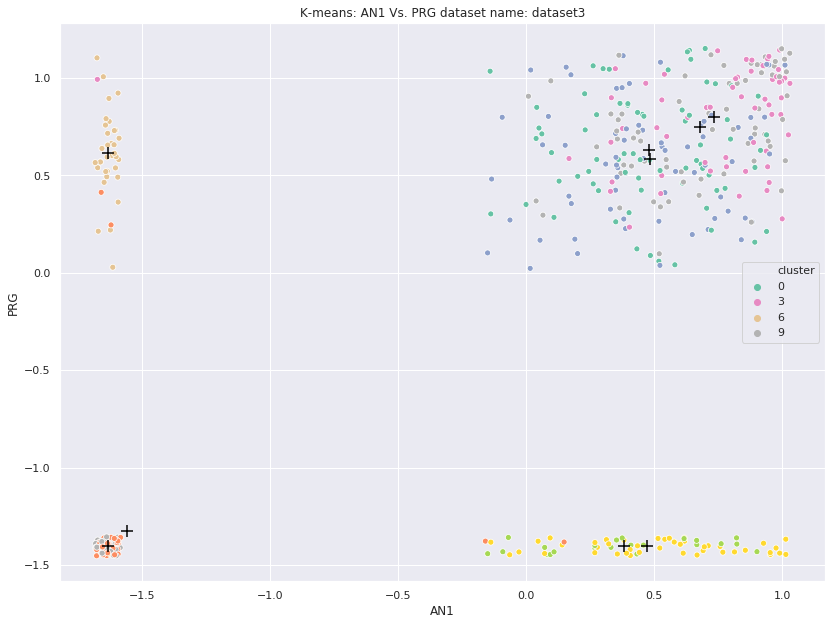

In [88]:
visDataKmeansJitter(datasetStandarKmean3, "AN1", "PRG", centroids3.AN1, centroids3.PRG, path1,"dataset3", jitter=0.5)

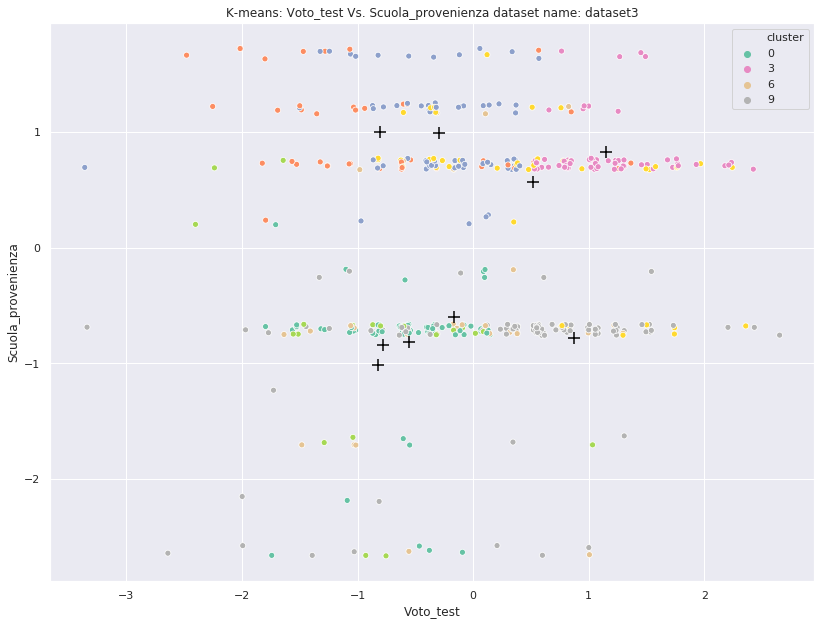

In [89]:
visDataKmeansJitter(datasetStandarKmean3, "Voto_test", "Scuola_provenienza", centroids3.Voto_test, centroids3.Scuola_provenienza, path1,"dataset3", jitter=0.5)

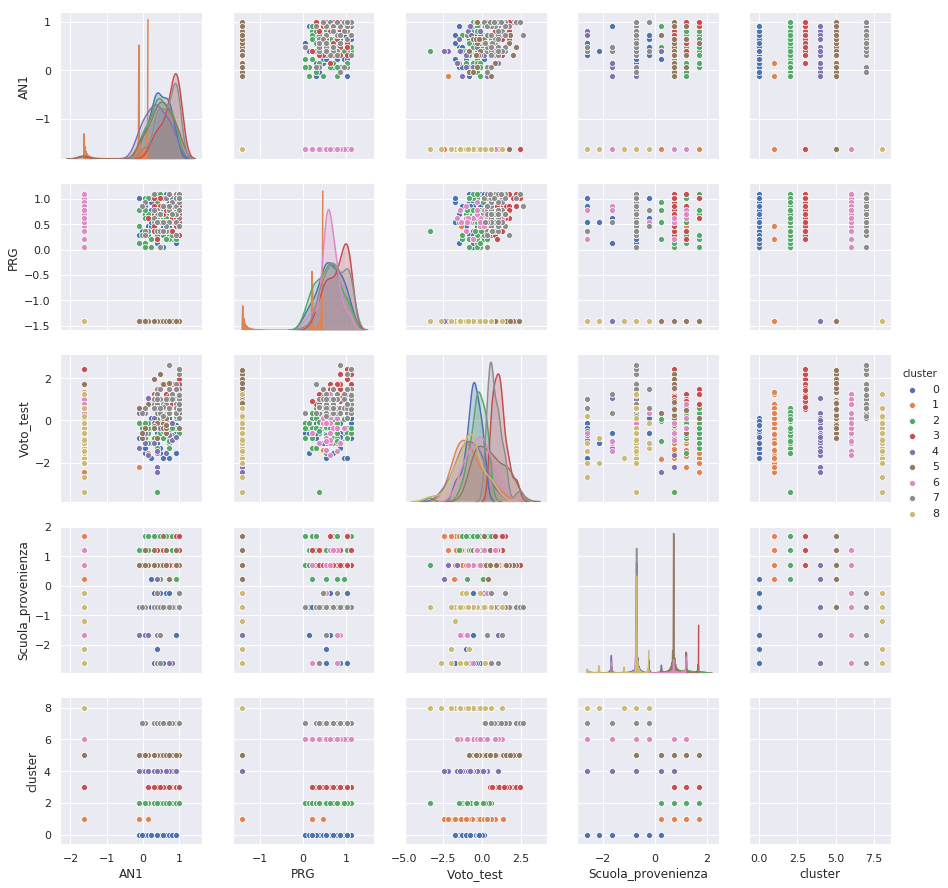

In [90]:
sns.pairplot(datasetStandarKmean3, hue="cluster")

In [91]:
groupByClusterKmeans3 = datasetKmeans3[["AN1","PRG","Voto_test","cluster"]].groupby("cluster").mean()
sc= datasetKmeans3[["Scuola_provenienza","cluster"]].groupby("cluster").apply(pd.DataFrame.mode).reset_index(drop=True).drop("cluster",axis=1)
groupByClusterKmeans3["Scuola_provenienza"] = sc
numStudenti3 = datasetKmeans3["cluster"].value_counts()


In [92]:
groupByClusterKmeans3

,AN1,PRG,Voto_test,Scuola_provenienza
cluster,,,,
0,24.972222,25.166667,-0.559531,4
1,0.866667,0.955556,-0.803502,7
2,25.042857,24.571429,-0.291531,7
3,27.966667,27.250000,1.151732,7
4,23.818182,0.000000,-0.782167,4
5,24.886364,0.000000,0.520174,7
6,0.000000,24.941176,-0.165847,4
7,27.352941,26.632353,0.868902,4
8,0.000000,0.000000,-0.825776,4


In [93]:
numStudenti3

0    72
2    70
7    68
3    60
1    45
5    44
8    38
6    34
4    22
Name: cluster, dtype: int64

## Commento dei risultati ottenuti con il K-means

>Il K-Means ha individuato 9 cluster. Cinque di questi cluster includono principalmente studenti provenienti dall'Istituto Tecnico (valore 4), mentre gli alti quattro cluster includono principalmente studenti che provengono dal Liceo Scientifico (valore 7). 
L'algoritmo ha quindi suddiviso gli studenti tra quelli che hanno dato entrambi gli esami, quelli che non li hanno dati, e quelli che ne hanno svolto solo uno.
Ancora una volta i cluster più grandi contengono gli studenti che hanno svolto entrambi gli esami, ma possiamo osservare che il cluster degli studenti del Liceo che hanno dato solo Analisi (Cluster 5) è molto più grande del cluster degli studenti dell'Istituto Tecnico che hanno dato solo Programmazione (Cluster 4), mentre non è stato individuato alcun cluster di studenti del Liceo Scientifico che abbiano dato solo Programmazione.

## Analisi dati con il DBSCAN

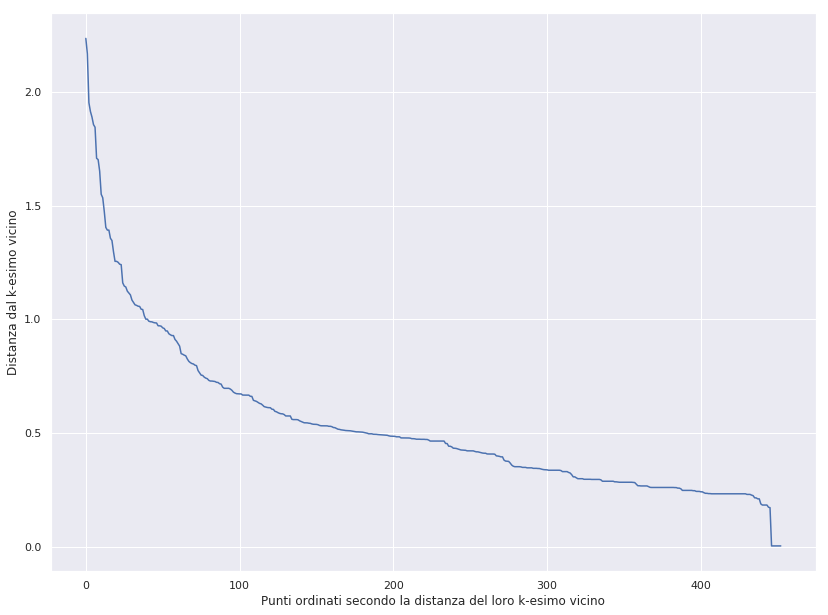

In [94]:
findParamerDBScan(dataset3,6)

In [95]:
datasetStandarDBScan3, datasetDBScan3 = dbScan(dataset3,0.625, 8)

clustering information  DBSCAN(algorithm='auto', eps=0.625, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=8, n_jobs=None, p=None)


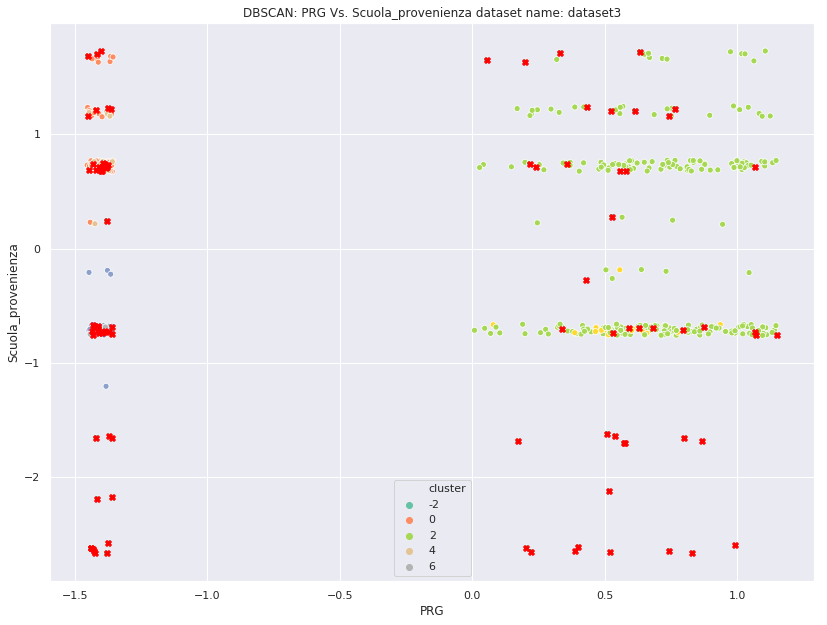

In [96]:
dataVisClusteringJitter(datasetStandarDBScan3,"PRG", "Scuola_provenienza", path2, "dataset3",clusteringName="dbscan", jitter=0.5)

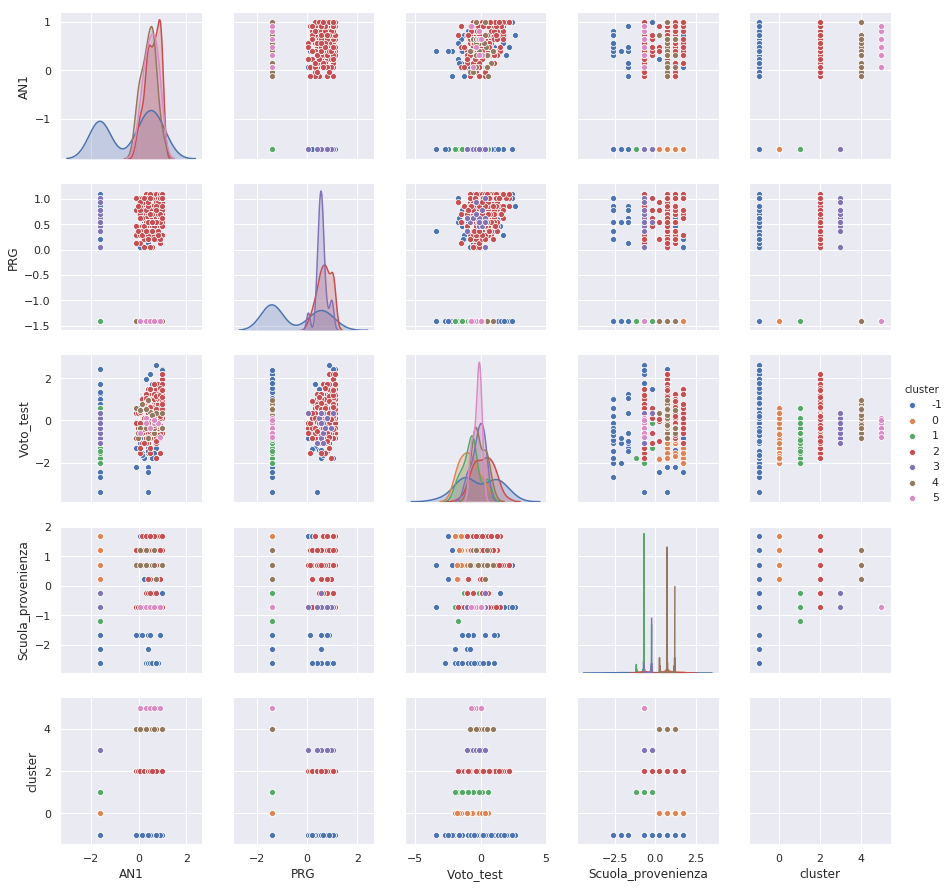

In [97]:
sns.pairplot(datasetStandarDBScan3, hue="cluster")

In [98]:
groupByClusterDBScan3 = datasetDBScan3.groupby("cluster").mean()
sc = datasetDBScan3[["Scuola_provenienza","cluster"]].groupby("cluster").apply(pd.DataFrame.mode).reset_index(drop=True).drop("cluster",axis=1)
groupByClusterDBScan3["Scuola_provenienza"] = sc
numStudenti = datasetDBScan3["cluster"].value_counts()

In [99]:
groupByClusterDBScan3

,AN1,PRG,Voto_test,Scuola_provenienza
cluster,,,,
-1,15.533333,11.700000,-0.089064,NaN
0,0.000000,0.000000,-0.867171,4.0
1,0.000000,0.000000,-0.672242,7.0
2,26.378049,26.012195,0.263904,4.0
3,0.000000,24.529412,-0.168042,4.0
4,24.296296,0.000000,-0.050612,4.0
5,25.500000,0.000000,-0.246039,7.0


In [100]:
numStudenti

 2    246
-1     90
 0     36
 1     29
 4     27
 3     17
 5      8
Name: cluster, dtype: int64

In [101]:
datasetClassification2 = dataset[["Genere","MDL","ASD","Coorte"]]
datasetClassification2["cluster"] = datasetHC3["cluster"]
datasetClassification2.to_csv(path_or_buf="../data/interim/datasetClassification2.csv", index=False)


### Commento dei risultati ottenuti con il DBSCAN

>Il DBSCAN ha individuato 6 cluster e 90 punti di rumore.
Ancora una volta il cluster più grande rappresenta gli studenti che hanno dato entrambi gli esami (cluster 2) e la moda della scuola di provenienza in questo gruppo è IT, essendo generalmente in numero maggiore.
I cluster 0 e 1 includono poi gli studenti che non hanno svolto nessuno dei due esami, divisi tra studenti che provengono dall'Istituto Tecnico e studenti che provengono dal Liceo.
Gli altri cluster includono studenti che hanno dato solo uno dei due esami, ma questa volta risultano essere cluster piuttosto piccoli.

## Commento generale sui risultati ottenuti

>Gli algoritmi di clustering utilizzati hanno solitamente diviso il dataset in gruppi abbastanza omogenei di studenti che hanno svolto etrambi gli esami, che non hanno svolto nessuno dei due o che ne hanno svolto uno solo, e non hanno messo in evidenza pattern molto particolari.
Comunque abbiamo potuto osservare nel caso del K-Means una maggiore tendenza da parte degli studenti del Liceo Scientifico a dare priorità all'esame di Analisi, mentre gli studenti dell'istituto tecnico danno priorità a Programmazione.
Questo risultato intuitivo non è stato né confermato né smentito dagli altri due metodi di clustering, indicando che tale tendeza è comunque piuttosto leggera.